In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed
gdrive = "."

In [2]:
#data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=3, image_size=1024):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        
        id_name_mask = id_name.replace(".JPG",".png")
        

        image_path = os.path.join(self.path, "images", id_name);
        mask_path = os.path.join(self.path, "masks", id_name_mask); #mascaras estao em .png
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.image_size));
        mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        mask = mask / 255.0;
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj

In [3]:

#hyperparameter
image_size = 256;
train_path = gdrive + "/data-640x480/"; #address of the dataset
#train_path = gdrive + "/data-1024x1024/"; #address of the dataset
epochs = 3; #number of time we need to train dataset
batch_size = 3; #tarining batch size

#train path
train_ids = os.listdir(train_path + "/images")
#Validation Data Size
val_data_size = 1; #size of set of images used for the validation 

valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
#print(valid_ids, "\n\n");
print("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, batch_size, image_size);
print("total epoch: ", len(gen))
#print(valid_ids)

training_size:  29 validation_size:  1
epoch completed
total epoch:  10


shape of the batch (3, 256, 256, 3) (3, 256, 256, 1)
Number of images in the batch:  3


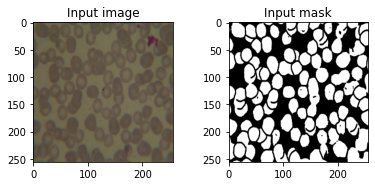

In [4]:
#Analysing sample of the dataset from data generator


#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print("shape of the batch", x.shape, y.shape);
print("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image

fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[2]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(np.reshape(y[2], (image_size, image_size)), cmap="gray");
plt.title("Input mask");

In [5]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [6]:
def UNet(size):
    if (size == 128):
        return UNet128()
    elif (size == 256):
        return UNet256()
    elif (size == 512):
        return UNet512()

#unet model
def UNet512():
    f = [16, 32, 64, 128, 256, 512, 1024]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 256
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 128
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 64
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 32
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 16
    c6, p6 = down_block(p5, f[5]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p6, f[6])
    
    u1 = up_block(bn, c6, f[5]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c5, f[4]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c4, f[3]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c3, f[2]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c2, f[1]) #upsampling layer upsmaples 8 image to 256
    u6 = up_block(u5, c1, f[0]) #upsampling layer upsmaples 8 image to 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u6)
    model = keras.models.Model(inputs, outputs)
    return model

def UNet256():
    f = [16, 32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 256
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 128
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 64
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 32
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 16
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c4, f[3]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c3, f[2]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c2, f[1]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c1, f[0]) #upsampling layer upsmaples 8 image to 256
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model


def UNet128():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 64
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 32
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 16
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c3, f[2]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c2, f[1]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c1, f[0]) #upsampling layer upsmaples 8 image to 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.title('train loss'); plt.ylabel('MSE loss'); plt.xlabel('epoch')
    plt.legend(['train loss'], loc='upper left')
    plt.show()
    plt.plot(history.history['acc'])
    plt.title('train accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
    plt.legend(['train accuracy'], loc='upper left')
    plt.show()

In [7]:
model = UNet(image_size)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
batch_size = 10
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size);
print("total training batches: ", len(train_gen));
print("total validaton batches: ", len(valid_gen));
train_steps = len(train_ids)//batch_size;
valid_steps = len(valid_ids)//batch_size;
epochs = 10000
versao = 1

_fileName = gdrive + "/cells-%d-%d-30-v%d.h5"
filename = _fileName % (image_size, epochs, versao)

print("filename:",filename)

epoch completed
epoch completed
total training batches:  3
total validaton batches:  1
filename: ./cells-256-10000-30-v1.h5


Epoch 1/10000
2/2 [==============================] - 3s 2s/step - loss: 0.6945 - acc: 0.4629
epoch completed
Epoch 2/10000
2/2 [==============================] - 1s 442ms/step - loss: 0.6780 - acc: 0.5438
epoch completed
Epoch 3/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6848 - acc: 0.5025
epoch completed
Epoch 4/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6903 - acc: 0.4865
epoch completed
Epoch 5/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6981 - acc: 0.4490
epoch completed
Epoch 6/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6996 - acc: 0.4377
epoch completed
Epoch 7/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6803 - acc: 0.5381
epoch completed
Epoch 8/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7058 - acc: 0.4196
epoch completed
Epoch 9/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6839 - acc: 0.5048
epoch compl

2/2 [==============================] - 1s 270ms/step - loss: 0.6845 - acc: 0.5068
epoch completed
Epoch 42/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6992 - acc: 0.4341
epoch completed
Epoch 43/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6923 - acc: 0.4873
epoch completed
Epoch 44/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6906 - acc: 0.4804
epoch completed
Epoch 45/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6862 - acc: 0.5096
epoch completed
Epoch 46/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6910 - acc: 0.4798
epoch completed
Epoch 47/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6960 - acc: 0.4542
epoch completed
Epoch 48/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6915 - acc: 0.4791
epoch completed
Epoch 49/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6888 - acc: 0.4990
epoch complete

2/2 [==============================] - 1s 272ms/step - loss: 0.6827 - acc: 0.5182
epoch completed
Epoch 82/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6814 - acc: 0.5277
epoch completed
Epoch 83/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6841 - acc: 0.5044
epoch completed
Epoch 84/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7009 - acc: 0.4285
epoch completed
Epoch 85/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6747 - acc: 0.5657
epoch completed
Epoch 86/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6836 - acc: 0.5098
epoch completed
Epoch 87/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6970 - acc: 0.4488
epoch completed
Epoch 88/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6886 - acc: 0.5006
epoch completed
Epoch 89/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6824 - acc: 0.5179
epoch complete

2/2 [==============================] - 1s 272ms/step - loss: 0.6910 - acc: 0.4818
epoch completed
Epoch 122/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7052 - acc: 0.4076
epoch completed
Epoch 123/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6909 - acc: 0.4800
epoch completed
Epoch 124/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6832 - acc: 0.5178
epoch completed
Epoch 125/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6999 - acc: 0.4273
epoch completed
Epoch 126/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6975 - acc: 0.4462
epoch completed
Epoch 127/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6787 - acc: 0.5348
epoch completed
Epoch 128/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6794 - acc: 0.5359
epoch completed
Epoch 129/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6851 - acc: 0.5159
epoch 

2/2 [==============================] - 1s 267ms/step - loss: 0.7040 - acc: 0.4243
epoch completed
Epoch 162/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6915 - acc: 0.4698
epoch completed
Epoch 163/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6824 - acc: 0.5200
epoch completed
Epoch 164/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6831 - acc: 0.5242
epoch completed
Epoch 165/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6807 - acc: 0.5279
epoch completed
Epoch 166/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6810 - acc: 0.5283
epoch completed
Epoch 167/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6867 - acc: 0.5033
epoch completed
Epoch 168/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6944 - acc: 0.4674
epoch completed
Epoch 169/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6927 - acc: 0.4621
epoch 

2/2 [==============================] - 1s 266ms/step - loss: 0.6966 - acc: 0.4641
epoch completed
Epoch 202/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6861 - acc: 0.4968
epoch completed
Epoch 203/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7020 - acc: 0.4230
epoch completed
Epoch 204/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7094 - acc: 0.3971
epoch completed
Epoch 205/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6988 - acc: 0.4414
epoch completed
Epoch 206/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7039 - acc: 0.4169
epoch completed
Epoch 207/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6915 - acc: 0.4698
epoch completed
Epoch 208/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6827 - acc: 0.5317
epoch completed
Epoch 209/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6933 - acc: 0.4687
epoch 

2/2 [==============================] - 1s 287ms/step - loss: 0.6946 - acc: 0.4612
epoch completed
Epoch 242/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6960 - acc: 0.4542
epoch completed
Epoch 243/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6897 - acc: 0.4859
epoch completed
Epoch 244/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6948 - acc: 0.4633
epoch completed
Epoch 245/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6809 - acc: 0.5255
epoch completed
Epoch 246/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7010 - acc: 0.4410
epoch completed
Epoch 247/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6855 - acc: 0.4990
epoch completed
Epoch 248/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6832 - acc: 0.5165
epoch completed
Epoch 249/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7034 - acc: 0.4132
epoch 

2/2 [==============================] - 1s 267ms/step - loss: 0.7128 - acc: 0.3706
epoch completed
Epoch 282/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6852 - acc: 0.4970
epoch completed
Epoch 283/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6826 - acc: 0.5187
epoch completed
Epoch 284/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7091 - acc: 0.3954
epoch completed
Epoch 285/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7096 - acc: 0.3966
epoch completed
Epoch 286/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6863 - acc: 0.4940
epoch completed
Epoch 287/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6778 - acc: 0.5496
epoch completed
Epoch 288/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6909 - acc: 0.4872
epoch completed
Epoch 289/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6803 - acc: 0.5246
epoch 

2/2 [==============================] - 1s 275ms/step - loss: 0.6982 - acc: 0.4403
epoch completed
Epoch 322/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6953 - acc: 0.4589
epoch completed
Epoch 323/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6826 - acc: 0.5151
epoch completed
Epoch 324/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7105 - acc: 0.3757
epoch completed
Epoch 325/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6989 - acc: 0.4377
epoch completed
Epoch 326/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6853 - acc: 0.4999
epoch completed
Epoch 327/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6836 - acc: 0.5085
epoch completed
Epoch 328/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6966 - acc: 0.4480
epoch completed
Epoch 329/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6973 - acc: 0.4451
epoch 

2/2 [==============================] - 1s 273ms/step - loss: 0.6892 - acc: 0.4945
epoch completed
Epoch 362/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6881 - acc: 0.4991
epoch completed
Epoch 363/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6832 - acc: 0.5242
epoch completed
Epoch 364/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6967 - acc: 0.4501
epoch completed
Epoch 365/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6833 - acc: 0.5165
epoch completed
Epoch 366/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6780 - acc: 0.5443
epoch completed
Epoch 367/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6834 - acc: 0.5154
epoch completed
Epoch 368/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6881 - acc: 0.5001
epoch completed
Epoch 369/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6923 - acc: 0.4873
epoch 

2/2 [==============================] - 1s 286ms/step - loss: 0.6839 - acc: 0.5125
epoch completed
Epoch 402/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6899 - acc: 0.4944
epoch completed
Epoch 403/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6769 - acc: 0.5498
epoch completed
Epoch 404/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.7161 - acc: 0.3594
epoch completed
Epoch 405/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7054 - acc: 0.4196
epoch completed
Epoch 406/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6834 - acc: 0.5149
epoch completed
Epoch 407/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6824 - acc: 0.5198
epoch completed
Epoch 408/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6846 - acc: 0.5167
epoch completed
Epoch 409/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7075 - acc: 0.4051
epoch 

2/2 [==============================] - 1s 269ms/step - loss: 0.6793 - acc: 0.5357
epoch completed
Epoch 442/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6893 - acc: 0.4917
epoch completed
Epoch 443/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6808 - acc: 0.5305
epoch completed
Epoch 444/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6815 - acc: 0.5245
epoch completed
Epoch 445/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6930 - acc: 0.4625
epoch completed
Epoch 446/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6908 - acc: 0.4819
epoch completed
Epoch 447/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6967 - acc: 0.4487
epoch completed
Epoch 448/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6836 - acc: 0.5073
epoch completed
Epoch 449/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6889 - acc: 0.4895
epoch 

2/2 [==============================] - 1s 266ms/step - loss: 0.6844 - acc: 0.5095
epoch completed
Epoch 482/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6912 - acc: 0.4819
epoch completed
Epoch 483/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6904 - acc: 0.4822
epoch completed
Epoch 484/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6929 - acc: 0.4718
epoch completed
Epoch 485/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6987 - acc: 0.4403
epoch completed
Epoch 486/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6969 - acc: 0.4488
epoch completed
Epoch 487/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7031 - acc: 0.4106
epoch completed
Epoch 488/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6960 - acc: 0.4641
epoch completed
Epoch 489/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6964 - acc: 0.4480
epoch 

2/2 [==============================] - 1s 268ms/step - loss: 0.6956 - acc: 0.4542
epoch completed
Epoch 522/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7027 - acc: 0.4106
epoch completed
Epoch 523/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7082 - acc: 0.3925
epoch completed
Epoch 524/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7006 - acc: 0.4382
epoch completed
Epoch 525/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6906 - acc: 0.4749
epoch completed
Epoch 526/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6854 - acc: 0.5025
epoch completed
Epoch 527/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6967 - acc: 0.4462
epoch completed
Epoch 528/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6863 - acc: 0.5074
epoch completed
Epoch 529/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6908 - acc: 0.4872
epoch 

2/2 [==============================] - 1s 271ms/step - loss: 0.6881 - acc: 0.4973
epoch completed
Epoch 562/10000
2/2 [==============================] - 1s 262ms/step - loss: 0.6820 - acc: 0.5199
epoch completed
Epoch 563/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6822 - acc: 0.5204
epoch completed
Epoch 564/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6947 - acc: 0.4658
epoch completed
Epoch 565/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6850 - acc: 0.4995
epoch completed
Epoch 566/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6909 - acc: 0.4800
epoch completed
Epoch 567/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6785 - acc: 0.5373
epoch completed
Epoch 568/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6812 - acc: 0.5226
epoch completed
Epoch 569/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6816 - acc: 0.5234
epoch 

2/2 [==============================] - 1s 270ms/step - loss: 0.6949 - acc: 0.4658
epoch completed
Epoch 602/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6811 - acc: 0.5209
epoch completed
Epoch 603/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6808 - acc: 0.5255
epoch completed
Epoch 604/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6856 - acc: 0.4977
epoch completed
Epoch 605/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6837 - acc: 0.5156
epoch completed
Epoch 606/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6779 - acc: 0.5496
epoch completed
Epoch 607/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7050 - acc: 0.4076
epoch completed
Epoch 608/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7049 - acc: 0.4113
epoch completed
Epoch 609/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6886 - acc: 0.4881
epoch 

2/2 [==============================] - 1s 278ms/step - loss: 0.6845 - acc: 0.5220
epoch completed
Epoch 642/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6897 - acc: 0.4859
epoch completed
Epoch 643/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6871 - acc: 0.5056
epoch completed
Epoch 644/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6789 - acc: 0.5333
epoch completed
Epoch 645/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6948 - acc: 0.4633
epoch completed
Epoch 646/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6842 - acc: 0.5048
epoch completed
Epoch 647/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6914 - acc: 0.4819
epoch completed
Epoch 648/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6766 - acc: 0.5472
epoch completed
Epoch 649/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6900 - acc: 0.4864
epoch 

2/2 [==============================] - 1s 276ms/step - loss: 0.6862 - acc: 0.5096
epoch completed
Epoch 682/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7026 - acc: 0.4214
epoch completed
Epoch 683/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6886 - acc: 0.4977
epoch completed
Epoch 684/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6871 - acc: 0.5056
epoch completed
Epoch 685/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6782 - acc: 0.5373
epoch completed
Epoch 686/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6811 - acc: 0.5235
epoch completed
Epoch 687/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6909 - acc: 0.4800
epoch completed
Epoch 688/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6829 - acc: 0.5178
epoch completed
Epoch 689/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7013 - acc: 0.4285
epoch 

2/2 [==============================] - 1s 271ms/step - loss: 0.6946 - acc: 0.4612
epoch completed
Epoch 722/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6887 - acc: 0.4937
epoch completed
Epoch 723/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7047 - acc: 0.4196
epoch completed
Epoch 724/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6881 - acc: 0.5001
epoch completed
Epoch 725/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6888 - acc: 0.4990
epoch completed
Epoch 726/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6861 - acc: 0.4978
epoch completed
Epoch 727/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6922 - acc: 0.4662
epoch completed
Epoch 728/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6835 - acc: 0.5126
epoch completed
Epoch 729/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6835 - acc: 0.5178
epoch 

2/2 [==============================] - 1s 266ms/step - loss: 0.6794 - acc: 0.5326
epoch completed
Epoch 762/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6831 - acc: 0.5242
epoch completed
Epoch 763/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6968 - acc: 0.4480
epoch completed
Epoch 764/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6841 - acc: 0.5037
epoch completed
Epoch 765/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6882 - acc: 0.5027
epoch completed
Epoch 766/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6825 - acc: 0.5212
epoch completed
Epoch 767/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6832 - acc: 0.5154
epoch completed
Epoch 768/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6824 - acc: 0.5212
epoch completed
Epoch 769/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6777 - acc: 0.5373
epoch 

2/2 [==============================] - 1s 269ms/step - loss: 0.6971 - acc: 0.4487
epoch completed
Epoch 802/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6821 - acc: 0.5182
epoch completed
Epoch 803/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6850 - acc: 0.5187
epoch completed
Epoch 804/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6952 - acc: 0.4613
epoch completed
Epoch 805/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6860 - acc: 0.4953
epoch completed
Epoch 806/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7028 - acc: 0.4180
epoch completed
Epoch 807/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6813 - acc: 0.5187
epoch completed
Epoch 808/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6828 - acc: 0.5242
epoch completed
Epoch 809/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6826 - acc: 0.5317
epoch 

2/2 [==============================] - 1s 272ms/step - loss: 0.7096 - acc: 0.3954
epoch completed
Epoch 842/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6856 - acc: 0.5131
epoch completed
Epoch 843/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6839 - acc: 0.5048
epoch completed
Epoch 844/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6869 - acc: 0.5056
epoch completed
Epoch 845/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 846/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6881 - acc: 0.4963
epoch completed
Epoch 847/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6860 - acc: 0.4953
epoch completed
Epoch 848/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6790 - acc: 0.5283
epoch completed
Epoch 849/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6989 - acc: 0.4299
epoch 

2/2 [==============================] - 1s 264ms/step - loss: 0.6856 - acc: 0.4949
epoch completed
Epoch 882/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6805 - acc: 0.5226
epoch completed
Epoch 883/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6972 - acc: 0.4499
epoch completed
Epoch 884/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6851 - acc: 0.4970
epoch completed
Epoch 885/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6781 - acc: 0.5333
epoch completed
Epoch 886/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6825 - acc: 0.5121
epoch completed
Epoch 887/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7057 - acc: 0.4122
epoch completed
Epoch 888/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6926 - acc: 0.4855
epoch completed
Epoch 889/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6796 - acc: 0.5235
epoch 

2/2 [==============================] - 1s 269ms/step - loss: 0.6857 - acc: 0.4978
epoch completed
Epoch 922/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7013 - acc: 0.4347
epoch completed
Epoch 923/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6752 - acc: 0.5527
epoch completed
Epoch 924/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6901 - acc: 0.4837
epoch completed
Epoch 925/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6819 - acc: 0.5163
epoch completed
Epoch 926/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6823 - acc: 0.5317
epoch completed
Epoch 927/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6880 - acc: 0.5001
epoch completed
Epoch 928/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6820 - acc: 0.5135
epoch completed
Epoch 929/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6948 - acc: 0.4559
epoch 

2/2 [==============================] - 1s 269ms/step - loss: 0.6908 - acc: 0.4749
epoch completed
Epoch 962/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6772 - acc: 0.5373
epoch completed
Epoch 963/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7047 - acc: 0.4131
epoch completed
Epoch 964/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7000 - acc: 0.4403
epoch completed
Epoch 965/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6914 - acc: 0.4819
epoch completed
Epoch 966/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6779 - acc: 0.5333
epoch completed
Epoch 967/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6777 - acc: 0.5407
epoch completed
Epoch 968/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6791 - acc: 0.5332
epoch completed
Epoch 969/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6808 - acc: 0.5276
epoch 

2/2 [==============================] - 1s 265ms/step - loss: 0.6766 - acc: 0.5385
epoch completed
Epoch 1002/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7031 - acc: 0.4230
epoch completed
Epoch 1003/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7071 - acc: 0.4196
epoch completed
Epoch 1004/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6960 - acc: 0.4687
epoch completed
Epoch 1005/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6826 - acc: 0.5162
epoch completed
Epoch 1006/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6863 - acc: 0.4969
epoch completed
Epoch 1007/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6829 - acc: 0.5149
epoch completed
Epoch 1008/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6995 - acc: 0.4431
epoch completed
Epoch 1009/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7008 - acc: 0.427

epoch completed
Epoch 1041/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6926 - acc: 0.4873
epoch completed
Epoch 1042/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6943 - acc: 0.4612
epoch completed
Epoch 1043/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6935 - acc: 0.4715
epoch completed
Epoch 1044/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6908 - acc: 0.4749
epoch completed
Epoch 1045/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7057 - acc: 0.4113
epoch completed
Epoch 1046/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6987 - acc: 0.4328
epoch completed
Epoch 1047/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6805 - acc: 0.5305
epoch completed
Epoch 1048/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6788 - acc: 0.5326
epoch completed
Epoch 1049/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 1081/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6849 - acc: 0.4996
epoch completed
Epoch 1082/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6801 - acc: 0.5255
epoch completed
Epoch 1083/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6791 - acc: 0.5388
epoch completed
Epoch 1084/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7001 - acc: 0.4341
epoch completed
Epoch 1085/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6824 - acc: 0.5121
epoch completed
Epoch 1086/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6811 - acc: 0.5227
epoch completed
Epoch 1087/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6828 - acc: 0.5073
epoch completed
Epoch 1088/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6836 - acc: 0.5037
epoch completed
Epoch 1089/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 1121/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6999 - acc: 0.4329
epoch completed
Epoch 1122/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6855 - acc: 0.4978
epoch completed
Epoch 1123/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6844 - acc: 0.5094
epoch completed
Epoch 1124/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6872 - acc: 0.5052
epoch completed
Epoch 1125/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6922 - acc: 0.4677
epoch completed
Epoch 1126/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7034 - acc: 0.4257
epoch completed
Epoch 1127/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6832 - acc: 0.5125
epoch completed
Epoch 1128/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6860 - acc: 0.4940
epoch completed
Epoch 1129/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 1161/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7047 - acc: 0.4214
epoch completed
Epoch 1162/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6966 - acc: 0.4612
epoch completed
Epoch 1163/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6950 - acc: 0.4559
epoch completed
Epoch 1164/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.7007 - acc: 0.4362
epoch completed
Epoch 1165/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7053 - acc: 0.4132
epoch completed
Epoch 1166/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6855 - acc: 0.4969
epoch completed
Epoch 1167/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6799 - acc: 0.5282
epoch completed
Epoch 1168/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6790 - acc: 0.5332
epoch completed
Epoch 1169/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 1201/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6965 - acc: 0.4611
epoch completed
Epoch 1202/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6977 - acc: 0.4501
epoch completed
Epoch 1203/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6973 - acc: 0.4533
epoch completed
Epoch 1204/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6863 - acc: 0.4969
epoch completed
Epoch 1205/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6786 - acc: 0.5359
epoch completed
Epoch 1206/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6819 - acc: 0.5163
epoch completed
Epoch 1207/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6825 - acc: 0.5242
epoch completed
Epoch 1208/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6943 - acc: 0.4714
epoch completed
Epoch 1209/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 1241/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.6808 - acc: 0.5245
epoch completed
Epoch 1242/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6817 - acc: 0.5151
epoch completed
Epoch 1243/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6984 - acc: 0.4596
epoch completed
Epoch 1244/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6868 - acc: 0.5056
epoch completed
Epoch 1245/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6847 - acc: 0.5159
epoch completed
Epoch 1246/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6855 - acc: 0.4969
epoch completed
Epoch 1247/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6801 - acc: 0.5283
epoch completed
Epoch 1248/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6987 - acc: 0.4451
epoch completed
Epoch 1249/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 1281/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6804 - acc: 0.5262
epoch completed
Epoch 1282/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6979 - acc: 0.4529
epoch completed
Epoch 1283/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6879 - acc: 0.5019
epoch completed
Epoch 1284/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6932 - acc: 0.4621
epoch completed
Epoch 1285/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6853 - acc: 0.5131
epoch completed
Epoch 1286/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6817 - acc: 0.5135
epoch completed
Epoch 1287/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6928 - acc: 0.4751
epoch completed
Epoch 1288/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6770 - acc: 0.5374
epoch completed
Epoch 1289/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 1321/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6872 - acc: 0.5033
epoch completed
Epoch 1322/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6907 - acc: 0.4840
epoch completed
Epoch 1323/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6807 - acc: 0.5248
epoch completed
Epoch 1324/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6751 - acc: 0.5465
epoch completed
Epoch 1325/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6987 - acc: 0.4528
epoch completed
Epoch 1326/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6919 - acc: 0.4809
epoch completed
Epoch 1327/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6911 - acc: 0.4830
epoch completed
Epoch 1328/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6901 - acc: 0.4846
epoch completed
Epoch 1329/10000
2/2 [==============================] - 1s 278ms

epoch completed
Epoch 1361/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6931 - acc: 0.4771
epoch completed
Epoch 1362/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6753 - acc: 0.5465
epoch completed
Epoch 1363/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7010 - acc: 0.4273
epoch completed
Epoch 1364/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6832 - acc: 0.5150
epoch completed
Epoch 1365/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7036 - acc: 0.4257
epoch completed
Epoch 1366/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6955 - acc: 0.4633
epoch completed
Epoch 1367/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6796 - acc: 0.5359
epoch completed
Epoch 1368/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6959 - acc: 0.4687
epoch completed
Epoch 1369/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 1401/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6857 - acc: 0.5158
epoch completed
Epoch 1402/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6987 - acc: 0.4299
epoch completed
Epoch 1403/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7043 - acc: 0.4106
epoch completed
Epoch 1404/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6911 - acc: 0.4818
epoch completed
Epoch 1405/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6795 - acc: 0.5304
epoch completed
Epoch 1406/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6968 - acc: 0.4487
epoch completed
Epoch 1407/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6881 - acc: 0.4946
epoch completed
Epoch 1408/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6944 - acc: 0.4559
epoch completed
Epoch 1409/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 1441/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6935 - acc: 0.4743
epoch completed
Epoch 1442/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7064 - acc: 0.4196
epoch completed
Epoch 1443/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6910 - acc: 0.4830
epoch completed
Epoch 1444/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6989 - acc: 0.4328
epoch completed
Epoch 1445/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6909 - acc: 0.4819
epoch completed
Epoch 1446/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6800 - acc: 0.5359
epoch completed
Epoch 1447/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6850 - acc: 0.5131
epoch completed
Epoch 1448/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6905 - acc: 0.4840
epoch completed
Epoch 1449/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 1481/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6957 - acc: 0.4589
epoch completed
Epoch 1482/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7055 - acc: 0.4113
epoch completed
Epoch 1483/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6821 - acc: 0.5151
epoch completed
Epoch 1484/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6850 - acc: 0.4999
epoch completed
Epoch 1485/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6881 - acc: 0.5027
epoch completed
Epoch 1486/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6913 - acc: 0.4789
epoch completed
Epoch 1487/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6903 - acc: 0.4865
epoch completed
Epoch 1488/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6774 - acc: 0.5373
epoch completed
Epoch 1489/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 1521/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6832 - acc: 0.5178
epoch completed
Epoch 1522/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6884 - acc: 0.4860
epoch completed
Epoch 1523/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7025 - acc: 0.4309
epoch completed
Epoch 1524/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6845 - acc: 0.5220
epoch completed
Epoch 1525/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6858 - acc: 0.4969
epoch completed
Epoch 1526/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6900 - acc: 0.4864
epoch completed
Epoch 1527/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6860 - acc: 0.4999
epoch completed
Epoch 1528/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.7126 - acc: 0.3706
epoch completed
Epoch 1529/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 1561/10000
2/2 [==============================] - 1s 256ms/step - loss: 0.6780 - acc: 0.5435
epoch completed
Epoch 1562/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6829 - acc: 0.5124
epoch completed
Epoch 1563/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7060 - acc: 0.4196
epoch completed
Epoch 1564/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6886 - acc: 0.4937
epoch completed
Epoch 1565/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6874 - acc: 0.5052
epoch completed
Epoch 1566/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6843 - acc: 0.5220
epoch completed
Epoch 1567/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6837 - acc: 0.5125
epoch completed
Epoch 1568/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6775 - acc: 0.5373
epoch completed
Epoch 1569/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 1601/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7018 - acc: 0.4336
epoch completed
Epoch 1602/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6980 - acc: 0.4377
epoch completed
Epoch 1603/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7117 - acc: 0.3925
epoch completed
Epoch 1604/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6752 - acc: 0.5518
epoch completed
Epoch 1605/10000
2/2 [==============================] - 0s 253ms/step - loss: 0.6818 - acc: 0.5200
epoch completed
Epoch 1606/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.6951 - acc: 0.4612
epoch completed
Epoch 1607/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6953 - acc: 0.4633
epoch completed
Epoch 1608/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6841 - acc: 0.4996
epoch completed
Epoch 1609/10000
2/2 [==============================] - 1s 276ms

epoch completed
Epoch 1641/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6939 - acc: 0.4603
epoch completed
Epoch 1642/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6771 - acc: 0.5373
epoch completed
Epoch 1643/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6803 - acc: 0.5260
epoch completed
Epoch 1644/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7148 - acc: 0.3706
epoch completed
Epoch 1645/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6879 - acc: 0.4973
epoch completed
Epoch 1646/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6840 - acc: 0.4996
epoch completed
Epoch 1647/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6866 - acc: 0.5045
epoch completed
Epoch 1648/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6834 - acc: 0.5074
epoch completed
Epoch 1649/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 1681/10000
2/2 [==============================] - 1s 288ms/step - loss: 0.6770 - acc: 0.5385
epoch completed
Epoch 1682/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6870 - acc: 0.5049
epoch completed
Epoch 1683/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6904 - acc: 0.4865
epoch completed
Epoch 1684/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6741 - acc: 0.5582
epoch completed
Epoch 1685/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6777 - acc: 0.5388
epoch completed
Epoch 1686/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6886 - acc: 0.4977
epoch completed
Epoch 1687/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6873 - acc: 0.5052
epoch completed
Epoch 1688/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6792 - acc: 0.5309
epoch completed
Epoch 1689/10000
2/2 [==============================] - 1s 277ms

epoch completed
Epoch 1721/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6738 - acc: 0.5518
epoch completed
Epoch 1722/10000
2/2 [==============================] - 1s 285ms/step - loss: 0.6836 - acc: 0.4996
epoch completed
Epoch 1723/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7238 - acc: 0.3509
epoch completed
Epoch 1724/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6913 - acc: 0.4830
epoch completed
Epoch 1725/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6810 - acc: 0.5179
epoch completed
Epoch 1726/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6902 - acc: 0.4846
epoch completed
Epoch 1727/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6774 - acc: 0.5357
epoch completed
Epoch 1728/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6790 - acc: 0.5255
epoch completed
Epoch 1729/10000
2/2 [==============================] - 1s 278ms

epoch completed
Epoch 1761/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6934 - acc: 0.4763
epoch completed
Epoch 1762/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6766 - acc: 0.5374
epoch completed
Epoch 1763/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6869 - acc: 0.5049
epoch completed
Epoch 1764/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6943 - acc: 0.4603
epoch completed
Epoch 1765/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6985 - acc: 0.4501
epoch completed
Epoch 1766/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6744 - acc: 0.5465
epoch completed
Epoch 1767/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6992 - acc: 0.4528
epoch completed
Epoch 1768/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6823 - acc: 0.5178
epoch completed
Epoch 1769/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 1801/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6819 - acc: 0.5165
epoch completed
Epoch 1802/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6984 - acc: 0.4487
epoch completed
Epoch 1803/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6839 - acc: 0.5000
epoch completed
Epoch 1804/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6805 - acc: 0.5253
epoch completed
Epoch 1805/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6852 - acc: 0.5057
epoch completed
Epoch 1806/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6916 - acc: 0.4798
epoch completed
Epoch 1807/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6782 - acc: 0.5235
epoch completed
Epoch 1808/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6843 - acc: 0.4999
epoch completed
Epoch 1809/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 1841/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6820 - acc: 0.5264
epoch completed
Epoch 1842/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6757 - acc: 0.5421
epoch completed
Epoch 1843/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6936 - acc: 0.4771
epoch completed
Epoch 1844/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6940 - acc: 0.4625
epoch completed
Epoch 1845/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6819 - acc: 0.5124
epoch completed
Epoch 1846/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7006 - acc: 0.4403
epoch completed
Epoch 1847/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6802 - acc: 0.5227
epoch completed
Epoch 1848/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6853 - acc: 0.4978
epoch completed
Epoch 1849/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 1881/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6872 - acc: 0.5034
epoch completed
Epoch 1882/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.7240 - acc: 0.3509
epoch completed
Epoch 1883/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6855 - acc: 0.5096
epoch completed
Epoch 1884/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6804 - acc: 0.5224
epoch completed
Epoch 1885/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6819 - acc: 0.5150
epoch completed
Epoch 1886/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7214 - acc: 0.3594
epoch completed
Epoch 1887/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6879 - acc: 0.5001
epoch completed
Epoch 1888/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6850 - acc: 0.4977
epoch completed
Epoch 1889/10000
2/2 [==============================] - 1s 289ms

epoch completed
Epoch 1921/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6797 - acc: 0.5234
epoch completed
Epoch 1922/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6854 - acc: 0.5131
epoch completed
Epoch 1923/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6881 - acc: 0.4946
epoch completed
Epoch 1924/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6826 - acc: 0.5165
epoch completed
Epoch 1925/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6956 - acc: 0.4613
epoch completed
Epoch 1926/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6850 - acc: 0.4990
epoch completed
Epoch 1927/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6945 - acc: 0.4612
epoch completed
Epoch 1928/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6833 - acc: 0.5150
epoch completed
Epoch 1929/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 1961/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7005 - acc: 0.4356
epoch completed
Epoch 1962/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6902 - acc: 0.4818
epoch completed
Epoch 1963/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6816 - acc: 0.5179
epoch completed
Epoch 1964/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6856 - acc: 0.5158
epoch completed
Epoch 1965/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 1966/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6823 - acc: 0.5178
epoch completed
Epoch 1967/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6997 - acc: 0.4444
epoch completed
Epoch 1968/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6827 - acc: 0.5264
epoch completed
Epoch 1969/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 2001/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6841 - acc: 0.5123
epoch completed
Epoch 2002/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6844 - acc: 0.5026
epoch completed
Epoch 2003/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6792 - acc: 0.5304
epoch completed
Epoch 2004/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6931 - acc: 0.4697
epoch completed
Epoch 2005/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6989 - acc: 0.4299
epoch completed
Epoch 2006/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6733 - acc: 0.5583
epoch completed
Epoch 2007/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6843 - acc: 0.5026
epoch completed
Epoch 2008/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6913 - acc: 0.4819
epoch completed
Epoch 2009/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 2041/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6799 - acc: 0.5268
epoch completed
Epoch 2042/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6827 - acc: 0.5126
epoch completed
Epoch 2043/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6770 - acc: 0.5385
epoch completed
Epoch 2044/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6740 - acc: 0.5582
epoch completed
Epoch 2045/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7132 - acc: 0.3865
epoch completed
Epoch 2046/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6817 - acc: 0.5151
epoch completed
Epoch 2047/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6974 - acc: 0.4487
epoch completed
Epoch 2048/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6797 - acc: 0.5381
epoch completed
Epoch 2049/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 2081/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6903 - acc: 0.4835
epoch completed
Epoch 2082/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7040 - acc: 0.4309
epoch completed
Epoch 2083/10000
2/2 [==============================] - 1s 287ms/step - loss: 0.6849 - acc: 0.4990
epoch completed
Epoch 2084/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7001 - acc: 0.4444
epoch completed
Epoch 2085/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6805 - acc: 0.5262
epoch completed
Epoch 2086/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7065 - acc: 0.4122
epoch completed
Epoch 2087/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6766 - acc: 0.5464
epoch completed
Epoch 2088/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7137 - acc: 0.3757
epoch completed
Epoch 2089/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 2121/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7040 - acc: 0.4169
epoch completed
Epoch 2122/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6785 - acc: 0.5382
epoch completed
Epoch 2123/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6973 - acc: 0.4454
epoch completed
Epoch 2124/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7092 - acc: 0.3954
epoch completed
Epoch 2125/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6803 - acc: 0.5268
epoch completed
Epoch 2126/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6852 - acc: 0.4970
epoch completed
Epoch 2127/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6918 - acc: 0.4677
epoch completed
Epoch 2128/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6952 - acc: 0.4588
epoch completed
Epoch 2129/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 2161/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6830 - acc: 0.5126
epoch completed
Epoch 2162/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7180 - acc: 0.3435
epoch completed
Epoch 2163/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6997 - acc: 0.4341
epoch completed
Epoch 2164/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6780 - acc: 0.5344
epoch completed
Epoch 2165/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6987 - acc: 0.4403
epoch completed
Epoch 2166/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6946 - acc: 0.4674
epoch completed
Epoch 2167/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6916 - acc: 0.4793
epoch completed
Epoch 2168/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6805 - acc: 0.5309
epoch completed
Epoch 2169/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 2201/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6896 - acc: 0.4865
epoch completed
Epoch 2202/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6794 - acc: 0.5283
epoch completed
Epoch 2203/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7115 - acc: 0.3865
epoch completed
Epoch 2204/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6865 - acc: 0.4969
epoch completed
Epoch 2205/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.6858 - acc: 0.5057
epoch completed
Epoch 2206/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 2207/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6860 - acc: 0.5081
epoch completed
Epoch 2208/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6888 - acc: 0.4972
epoch completed
Epoch 2209/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 2241/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6959 - acc: 0.4611
epoch completed
Epoch 2242/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 2243/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6972 - acc: 0.4458
epoch completed
Epoch 2244/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6792 - acc: 0.5421
epoch completed
Epoch 2245/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6783 - acc: 0.5344
epoch completed
Epoch 2246/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6858 - acc: 0.4949
epoch completed
Epoch 2247/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6795 - acc: 0.5381
epoch completed
Epoch 2248/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6837 - acc: 0.5076
epoch completed
Epoch 2249/10000
2/2 [==============================] - 1s 264ms

epoch completed
Epoch 2281/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6847 - acc: 0.4995
epoch completed
Epoch 2282/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7025 - acc: 0.4309
epoch completed
Epoch 2283/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7115 - acc: 0.3757
epoch completed
Epoch 2284/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7012 - acc: 0.4410
epoch completed
Epoch 2285/10000
2/2 [==============================] - 1s 285ms/step - loss: 0.6868 - acc: 0.5045
epoch completed
Epoch 2286/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6953 - acc: 0.4559
epoch completed
Epoch 2287/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6830 - acc: 0.5121
epoch completed
Epoch 2288/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6927 - acc: 0.4771
epoch completed
Epoch 2289/10000
2/2 [==============================] - 1s 282ms

epoch completed
Epoch 2321/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6860 - acc: 0.5096
epoch completed
Epoch 2322/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6758 - acc: 0.5527
epoch completed
Epoch 2323/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6919 - acc: 0.4677
epoch completed
Epoch 2324/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6783 - acc: 0.5333
epoch completed
Epoch 2325/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6867 - acc: 0.5045
epoch completed
Epoch 2326/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6857 - acc: 0.5057
epoch completed
Epoch 2327/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6780 - acc: 0.5374
epoch completed
Epoch 2328/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6875 - acc: 0.5007
epoch completed
Epoch 2329/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 2361/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6870 - acc: 0.5003
epoch completed
Epoch 2362/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6819 - acc: 0.5123
epoch completed
Epoch 2363/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6998 - acc: 0.4403
epoch completed
Epoch 2364/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6869 - acc: 0.5049
epoch completed
Epoch 2365/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6864 - acc: 0.4944
epoch completed
Epoch 2366/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6947 - acc: 0.4714
epoch completed
Epoch 2367/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6836 - acc: 0.5095
epoch completed
Epoch 2368/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6868 - acc: 0.5032
epoch completed
Epoch 2369/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 2401/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6911 - acc: 0.4830
epoch completed
Epoch 2402/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6974 - acc: 0.4427
epoch completed
Epoch 2403/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6961 - acc: 0.4559
epoch completed
Epoch 2404/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6947 - acc: 0.4594
epoch completed
Epoch 2405/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7073 - acc: 0.4196
epoch completed
Epoch 2406/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6956 - acc: 0.4658
epoch completed
Epoch 2407/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6792 - acc: 0.5338
epoch completed
Epoch 2408/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6839 - acc: 0.5103
epoch completed
Epoch 2409/10000
2/2 [==============================] - 1s 260ms

epoch completed
Epoch 2441/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7001 - acc: 0.4414
epoch completed
Epoch 2442/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6869 - acc: 0.4922
epoch completed
Epoch 2443/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6784 - acc: 0.5388
epoch completed
Epoch 2444/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6892 - acc: 0.4945
epoch completed
Epoch 2445/10000
2/2 [==============================] - 1s 255ms/step - loss: 0.6958 - acc: 0.4633
epoch completed
Epoch 2446/10000
2/2 [==============================] - 1s 283ms/step - loss: 0.7044 - acc: 0.4327
epoch completed
Epoch 2447/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6868 - acc: 0.5032
epoch completed
Epoch 2448/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6824 - acc: 0.5178
epoch completed
Epoch 2449/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 2481/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6827 - acc: 0.5165
epoch completed
Epoch 2482/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6881 - acc: 0.5027
epoch completed
Epoch 2483/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6804 - acc: 0.5249
epoch completed
Epoch 2484/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6867 - acc: 0.5045
epoch completed
Epoch 2485/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6869 - acc: 0.5056
epoch completed
Epoch 2486/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6869 - acc: 0.5028
epoch completed
Epoch 2487/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6838 - acc: 0.5241
epoch completed
Epoch 2488/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6857 - acc: 0.5074
epoch completed
Epoch 2489/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 2521/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6807 - acc: 0.5245
epoch completed
Epoch 2522/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6982 - acc: 0.4488
epoch completed
Epoch 2523/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6822 - acc: 0.5149
epoch completed
Epoch 2524/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6909 - acc: 0.4819
epoch completed
Epoch 2525/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7061 - acc: 0.4084
epoch completed
Epoch 2526/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6933 - acc: 0.4697
epoch completed
Epoch 2527/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6937 - acc: 0.4715
epoch completed
Epoch 2528/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6960 - acc: 0.4559
epoch completed
Epoch 2529/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 2561/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6889 - acc: 0.4895
epoch completed
Epoch 2562/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6813 - acc: 0.5233
epoch completed
Epoch 2563/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6847 - acc: 0.5025
epoch completed
Epoch 2564/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6851 - acc: 0.4978
epoch completed
Epoch 2565/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7170 - acc: 0.3594
epoch completed
Epoch 2566/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6973 - acc: 0.4487
epoch completed
Epoch 2567/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6928 - acc: 0.4775
epoch completed
Epoch 2568/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6893 - acc: 0.4917
epoch completed
Epoch 2569/10000
2/2 [==============================] - 1s 278ms

epoch completed
Epoch 2601/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6948 - acc: 0.4589
epoch completed
Epoch 2602/10000
2/2 [==============================] - 1s 260ms/step - loss: 0.6868 - acc: 0.5045
epoch completed
Epoch 2603/10000
2/2 [==============================] - 1s 284ms/step - loss: 0.6874 - acc: 0.5033
epoch completed
Epoch 2604/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6846 - acc: 0.5025
epoch completed
Epoch 2605/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6831 - acc: 0.5165
epoch completed
Epoch 2606/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6899 - acc: 0.4944
epoch completed
Epoch 2607/10000
2/2 [==============================] - 1s 283ms/step - loss: 0.6870 - acc: 0.5032
epoch completed
Epoch 2608/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6880 - acc: 0.5001
epoch completed
Epoch 2609/10000
2/2 [==============================] - 1s 264ms

epoch completed
Epoch 2641/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6793 - acc: 0.5354
epoch completed
Epoch 2642/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6788 - acc: 0.5344
epoch completed
Epoch 2643/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6889 - acc: 0.4895
epoch completed
Epoch 2644/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7018 - acc: 0.4257
epoch completed
Epoch 2645/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6905 - acc: 0.4776
epoch completed
Epoch 2646/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6885 - acc: 0.4860
epoch completed
Epoch 2647/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6827 - acc: 0.5179
epoch completed
Epoch 2648/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7019 - acc: 0.4180
epoch completed
Epoch 2649/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 2681/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6845 - acc: 0.5036
epoch completed
Epoch 2682/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6783 - acc: 0.5421
epoch completed
Epoch 2683/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7084 - acc: 0.3892
epoch completed
Epoch 2684/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6845 - acc: 0.5103
epoch completed
Epoch 2685/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6815 - acc: 0.5234
epoch completed
Epoch 2686/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6806 - acc: 0.5268
epoch completed
Epoch 2687/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6786 - acc: 0.5463
epoch completed
Epoch 2688/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6906 - acc: 0.4776
epoch completed
Epoch 2689/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 2721/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6968 - acc: 0.4499
epoch completed
Epoch 2722/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6833 - acc: 0.5098
epoch completed
Epoch 2723/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6824 - acc: 0.5198
epoch completed
Epoch 2724/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6958 - acc: 0.4516
epoch completed
Epoch 2725/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6905 - acc: 0.4822
epoch completed
Epoch 2726/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7043 - acc: 0.4243
epoch completed
Epoch 2727/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7036 - acc: 0.4131
epoch completed
Epoch 2728/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6870 - acc: 0.5032
epoch completed
Epoch 2729/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 2761/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6821 - acc: 0.5211
epoch completed
Epoch 2762/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6774 - acc: 0.5517
epoch completed
Epoch 2763/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6837 - acc: 0.5076
epoch completed
Epoch 2764/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6845 - acc: 0.5220
epoch completed
Epoch 2765/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6816 - acc: 0.5233
epoch completed
Epoch 2766/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6906 - acc: 0.4804
epoch completed
Epoch 2767/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6922 - acc: 0.4650
epoch completed
Epoch 2768/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6790 - acc: 0.5357
epoch completed
Epoch 2769/10000
2/2 [==============================] - 1s 264ms

epoch completed
Epoch 2801/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6991 - acc: 0.4403
epoch completed
Epoch 2802/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6911 - acc: 0.4818
epoch completed
Epoch 2803/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6796 - acc: 0.5235
epoch completed
Epoch 2804/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6826 - acc: 0.5242
epoch completed
Epoch 2805/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6820 - acc: 0.5124
epoch completed
Epoch 2806/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6911 - acc: 0.4800
epoch completed
Epoch 2807/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6825 - acc: 0.5242
epoch completed
Epoch 2808/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6834 - acc: 0.5044
epoch completed
Epoch 2809/10000
2/2 [==============================] - 1s 283ms

epoch completed
Epoch 2841/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6993 - acc: 0.4444
epoch completed
Epoch 2842/10000
2/2 [==============================] - 1s 253ms/step - loss: 0.6928 - acc: 0.4621
epoch completed
Epoch 2843/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6926 - acc: 0.4650
epoch completed
Epoch 2844/10000
2/2 [==============================] - 1s 283ms/step - loss: 0.6804 - acc: 0.5279
epoch completed
Epoch 2845/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6789 - acc: 0.5326
epoch completed
Epoch 2846/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6807 - acc: 0.5226
epoch completed
Epoch 2847/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6860 - acc: 0.5096
epoch completed
Epoch 2848/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7012 - acc: 0.4318
epoch completed
Epoch 2849/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 2881/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6923 - acc: 0.4873
epoch completed
Epoch 2882/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6825 - acc: 0.5198
epoch completed
Epoch 2883/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6828 - acc: 0.5178
epoch completed
Epoch 2884/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6888 - acc: 0.4990
epoch completed
Epoch 2885/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6868 - acc: 0.5045
epoch completed
Epoch 2886/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6804 - acc: 0.5310
epoch completed
Epoch 2887/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6985 - acc: 0.4431
epoch completed
Epoch 2888/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6850 - acc: 0.5094
epoch completed
Epoch 2889/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 2921/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6829 - acc: 0.5094
epoch completed
Epoch 2922/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6858 - acc: 0.5057
epoch completed
Epoch 2923/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6969 - acc: 0.4499
epoch completed
Epoch 2924/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6973 - acc: 0.4377
epoch completed
Epoch 2925/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7142 - acc: 0.3695
epoch completed
Epoch 2926/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6785 - acc: 0.5374
epoch completed
Epoch 2927/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6975 - acc: 0.4462
epoch completed
Epoch 2928/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6935 - acc: 0.4827
epoch completed
Epoch 2929/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 2961/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6865 - acc: 0.4968
epoch completed
Epoch 2962/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6813 - acc: 0.5381
epoch completed
Epoch 2963/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6962 - acc: 0.4533
epoch completed
Epoch 2964/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6841 - acc: 0.5132
epoch completed
Epoch 2965/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6851 - acc: 0.5000
epoch completed
Epoch 2966/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6974 - acc: 0.4329
epoch completed
Epoch 2967/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6980 - acc: 0.4329
epoch completed
Epoch 2968/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7085 - acc: 0.3925
epoch completed
Epoch 2969/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 3001/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7030 - acc: 0.4281
epoch completed
Epoch 3002/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6881 - acc: 0.5019
epoch completed
Epoch 3003/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6793 - acc: 0.5354
epoch completed
Epoch 3004/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6886 - acc: 0.5006
epoch completed
Epoch 3005/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6825 - acc: 0.5208
epoch completed
Epoch 3006/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6807 - acc: 0.5308
epoch completed
Epoch 3007/10000
2/2 [==============================] - 1s 284ms/step - loss: 0.6986 - acc: 0.4444
epoch completed
Epoch 3008/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6965 - acc: 0.4533
epoch completed
Epoch 3009/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 3041/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6961 - acc: 0.4659
epoch completed
Epoch 3042/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6861 - acc: 0.5057
epoch completed
Epoch 3043/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6815 - acc: 0.5283
epoch completed
Epoch 3044/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7032 - acc: 0.4225
epoch completed
Epoch 3045/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6826 - acc: 0.5179
epoch completed
Epoch 3046/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6861 - acc: 0.4949
epoch completed
Epoch 3047/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6849 - acc: 0.5007
epoch completed
Epoch 3048/10000
2/2 [==============================] - 0s 254ms/step - loss: 0.7015 - acc: 0.4180
epoch completed
Epoch 3049/10000
2/2 [==============================] - 1s 292ms

epoch completed
Epoch 3081/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6823 - acc: 0.5211
epoch completed
Epoch 3082/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6940 - acc: 0.4696
epoch completed
Epoch 3083/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6769 - acc: 0.5465
epoch completed
Epoch 3084/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6930 - acc: 0.4625
epoch completed
Epoch 3085/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6845 - acc: 0.4996
epoch completed
Epoch 3086/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6844 - acc: 0.5123
epoch completed
Epoch 3087/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6985 - acc: 0.4414
epoch completed
Epoch 3088/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6918 - acc: 0.4677
epoch completed
Epoch 3089/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 3121/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7020 - acc: 0.4214
epoch completed
Epoch 3122/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6896 - acc: 0.4865
epoch completed
Epoch 3123/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6810 - acc: 0.5235
epoch completed
Epoch 3124/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6813 - acc: 0.5234
epoch completed
Epoch 3125/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6810 - acc: 0.5366
epoch completed
Epoch 3126/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6928 - acc: 0.4718
epoch completed
Epoch 3127/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6941 - acc: 0.4674
epoch completed
Epoch 3128/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6853 - acc: 0.5011
epoch completed
Epoch 3129/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 3161/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6896 - acc: 0.4865
epoch completed
Epoch 3162/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6843 - acc: 0.5074
epoch completed
Epoch 3163/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6914 - acc: 0.4698
epoch completed
Epoch 3164/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6965 - acc: 0.4480
epoch completed
Epoch 3165/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6838 - acc: 0.5085
epoch completed
Epoch 3166/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6955 - acc: 0.4611
epoch completed
Epoch 3167/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6927 - acc: 0.4697
epoch completed
Epoch 3168/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6773 - acc: 0.5518
epoch completed
Epoch 3169/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 3201/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6821 - acc: 0.5172
epoch completed
Epoch 3202/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6862 - acc: 0.4953
epoch completed
Epoch 3203/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6811 - acc: 0.5305
epoch completed
Epoch 3204/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6811 - acc: 0.5305
epoch completed
Epoch 3205/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6900 - acc: 0.4837
epoch completed
Epoch 3206/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6853 - acc: 0.5017
epoch completed
Epoch 3207/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6833 - acc: 0.5264
epoch completed
Epoch 3208/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6811 - acc: 0.5226
epoch completed
Epoch 3209/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 3241/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6850 - acc: 0.5187
epoch completed
Epoch 3242/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6953 - acc: 0.4641
epoch completed
Epoch 3243/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6802 - acc: 0.5268
epoch completed
Epoch 3244/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6831 - acc: 0.5098
epoch completed
Epoch 3245/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7094 - acc: 0.3971
epoch completed
Epoch 3246/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6886 - acc: 0.4977
epoch completed
Epoch 3247/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6974 - acc: 0.4377
epoch completed
Epoch 3248/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7054 - acc: 0.4076
epoch completed
Epoch 3249/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 3281/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6977 - acc: 0.4596
epoch completed
Epoch 3282/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6782 - acc: 0.5344
epoch completed
Epoch 3283/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6822 - acc: 0.5182
epoch completed
Epoch 3284/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7115 - acc: 0.3757
epoch completed
Epoch 3285/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6808 - acc: 0.5305
epoch completed
Epoch 3286/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7013 - acc: 0.4410
epoch completed
Epoch 3287/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6928 - acc: 0.4651
epoch completed
Epoch 3288/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6824 - acc: 0.5179
epoch completed
Epoch 3289/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 3321/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6798 - acc: 0.5388
epoch completed
Epoch 3322/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6804 - acc: 0.5256
epoch completed
Epoch 3323/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6903 - acc: 0.4847
epoch completed
Epoch 3324/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6861 - acc: 0.4953
epoch completed
Epoch 3325/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6797 - acc: 0.5304
epoch completed
Epoch 3326/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6998 - acc: 0.4356
epoch completed
Epoch 3327/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7089 - acc: 0.3954
epoch completed
Epoch 3328/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6889 - acc: 0.4913
epoch completed
Epoch 3329/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 3361/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6826 - acc: 0.5135
epoch completed
Epoch 3362/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6924 - acc: 0.4855
epoch completed
Epoch 3363/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6864 - acc: 0.4940
epoch completed
Epoch 3364/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7098 - acc: 0.3925
epoch completed
Epoch 3365/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6918 - acc: 0.4677
epoch completed
Epoch 3366/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6913 - acc: 0.4789
epoch completed
Epoch 3367/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6842 - acc: 0.5048
epoch completed
Epoch 3368/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6977 - acc: 0.4451
epoch completed
Epoch 3369/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 3401/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6888 - acc: 0.4990
epoch completed
Epoch 3402/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6984 - acc: 0.4303
epoch completed
Epoch 3403/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6949 - acc: 0.4641
epoch completed
Epoch 3404/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6853 - acc: 0.5187
epoch completed
Epoch 3405/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6938 - acc: 0.4714
epoch completed
Epoch 3406/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6887 - acc: 0.4977
epoch completed
Epoch 3407/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6966 - acc: 0.4480
epoch completed
Epoch 3408/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6921 - acc: 0.4662
epoch completed
Epoch 3409/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 3441/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6829 - acc: 0.5150
epoch completed
Epoch 3442/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6917 - acc: 0.4677
epoch completed
Epoch 3443/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6782 - acc: 0.5496
epoch completed
Epoch 3444/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6841 - acc: 0.5125
epoch completed
Epoch 3445/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6791 - acc: 0.5354
epoch completed
Epoch 3446/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6820 - acc: 0.5204
epoch completed
Epoch 3447/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6858 - acc: 0.4949
epoch completed
Epoch 3448/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6831 - acc: 0.5179
epoch completed
Epoch 3449/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 3481/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6955 - acc: 0.4516
epoch completed
Epoch 3482/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6945 - acc: 0.4612
epoch completed
Epoch 3483/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7054 - acc: 0.3954
epoch completed
Epoch 3484/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7058 - acc: 0.4028
epoch completed
Epoch 3485/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6863 - acc: 0.5096
epoch completed
Epoch 3486/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6835 - acc: 0.5179
epoch completed
Epoch 3487/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6949 - acc: 0.4559
epoch completed
Epoch 3488/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6928 - acc: 0.4625
epoch completed
Epoch 3489/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 3521/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6851 - acc: 0.5011
epoch completed
Epoch 3522/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6876 - acc: 0.5007
epoch completed
Epoch 3523/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6951 - acc: 0.4559
epoch completed
Epoch 3524/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6862 - acc: 0.4953
epoch completed
Epoch 3525/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7117 - acc: 0.3706
epoch completed
Epoch 3526/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6967 - acc: 0.4557
epoch completed
Epoch 3527/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6885 - acc: 0.4860
epoch completed
Epoch 3528/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6910 - acc: 0.4818
epoch completed
Epoch 3529/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 3561/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7035 - acc: 0.4225
epoch completed
Epoch 3562/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6947 - acc: 0.4633
epoch completed
Epoch 3563/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6856 - acc: 0.5000
epoch completed
Epoch 3564/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6900 - acc: 0.4837
epoch completed
Epoch 3565/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6882 - acc: 0.4946
epoch completed
Epoch 3566/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6972 - acc: 0.4462
epoch completed
Epoch 3567/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6931 - acc: 0.4715
epoch completed
Epoch 3568/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6860 - acc: 0.5158
epoch completed
Epoch 3569/10000
2/2 [==============================] - 1s 280ms

epoch completed
Epoch 3601/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6834 - acc: 0.5124
epoch completed
Epoch 3602/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6791 - acc: 0.5360
epoch completed
Epoch 3603/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6950 - acc: 0.4586
epoch completed
Epoch 3604/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6964 - acc: 0.4487
epoch completed
Epoch 3605/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6921 - acc: 0.4650
epoch completed
Epoch 3606/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7087 - acc: 0.3966
epoch completed
Epoch 3607/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6855 - acc: 0.4970
epoch completed
Epoch 3608/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6831 - acc: 0.5123
epoch completed
Epoch 3609/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 3641/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6970 - acc: 0.4458
epoch completed
Epoch 3642/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6804 - acc: 0.5321
epoch completed
Epoch 3643/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7033 - acc: 0.4169
epoch completed
Epoch 3644/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6819 - acc: 0.5199
epoch completed
Epoch 3645/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6846 - acc: 0.5103
epoch completed
Epoch 3646/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6789 - acc: 0.5360
epoch completed
Epoch 3647/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6991 - acc: 0.4341
epoch completed
Epoch 3648/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6781 - acc: 0.5464
epoch completed
Epoch 3649/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 3681/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6906 - acc: 0.4804
epoch completed
Epoch 3682/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6802 - acc: 0.5338
epoch completed
Epoch 3683/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6809 - acc: 0.5249
epoch completed
Epoch 3684/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6883 - acc: 0.4934
epoch completed
Epoch 3685/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6979 - acc: 0.4329
epoch completed
Epoch 3686/10000
2/2 [==============================] - 1s 283ms/step - loss: 0.6932 - acc: 0.4715
epoch completed
Epoch 3687/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6884 - acc: 0.4860
epoch completed
Epoch 3688/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6827 - acc: 0.5187
epoch completed
Epoch 3689/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 3721/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6778 - acc: 0.5373
epoch completed
Epoch 3722/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6762 - acc: 0.5527
epoch completed
Epoch 3723/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6821 - acc: 0.5208
epoch completed
Epoch 3724/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7000 - acc: 0.4273
epoch completed
Epoch 3725/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6896 - acc: 0.4859
epoch completed
Epoch 3726/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6819 - acc: 0.5234
epoch completed
Epoch 3727/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7007 - acc: 0.4411
epoch completed
Epoch 3728/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6880 - acc: 0.5001
epoch completed
Epoch 3729/10000
2/2 [==============================] - 1s 292ms

epoch completed
Epoch 3761/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6995 - acc: 0.4377
epoch completed
Epoch 3762/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6880 - acc: 0.4986
epoch completed
Epoch 3763/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6854 - acc: 0.5000
epoch completed
Epoch 3764/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6845 - acc: 0.5220
epoch completed
Epoch 3765/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6796 - acc: 0.5317
epoch completed
Epoch 3766/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6867 - acc: 0.5033
epoch completed
Epoch 3767/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6830 - acc: 0.5165
epoch completed
Epoch 3768/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6860 - acc: 0.5096
epoch completed
Epoch 3769/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 3801/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6949 - acc: 0.4589
epoch completed
Epoch 3802/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6823 - acc: 0.5198
epoch completed
Epoch 3803/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6943 - acc: 0.4538
epoch completed
Epoch 3804/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6767 - acc: 0.5498
epoch completed
Epoch 3805/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6782 - acc: 0.5463
epoch completed
Epoch 3806/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6835 - acc: 0.5121
epoch completed
Epoch 3807/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6780 - acc: 0.5344
epoch completed
Epoch 3808/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7029 - acc: 0.4180
epoch completed
Epoch 3809/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 3841/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6804 - acc: 0.5309
epoch completed
Epoch 3842/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6817 - acc: 0.5262
epoch completed
Epoch 3843/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6862 - acc: 0.4953
epoch completed
Epoch 3844/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6967 - acc: 0.4501
epoch completed
Epoch 3845/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6827 - acc: 0.5163
epoch completed
Epoch 3846/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6815 - acc: 0.5230
epoch completed
Epoch 3847/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6849 - acc: 0.5037
epoch completed
Epoch 3848/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6767 - acc: 0.5472
epoch completed
Epoch 3849/10000
2/2 [==============================] - 1s 264ms

epoch completed
Epoch 3881/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6835 - acc: 0.5121
epoch completed
Epoch 3882/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6818 - acc: 0.5224
epoch completed
Epoch 3883/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6845 - acc: 0.5025
epoch completed
Epoch 3884/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6886 - acc: 0.5006
epoch completed
Epoch 3885/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6893 - acc: 0.4917
epoch completed
Epoch 3886/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6928 - acc: 0.4621
epoch completed
Epoch 3887/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6985 - acc: 0.4328
epoch completed
Epoch 3888/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6941 - acc: 0.4714
epoch completed
Epoch 3889/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 3921/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6958 - acc: 0.4537
epoch completed
Epoch 3922/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6827 - acc: 0.5264
epoch completed
Epoch 3923/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6816 - acc: 0.5211
epoch completed
Epoch 3924/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6821 - acc: 0.5187
epoch completed
Epoch 3925/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7046 - acc: 0.4281
epoch completed
Epoch 3926/10000
2/2 [==============================] - 1s 283ms/step - loss: 0.6848 - acc: 0.5159
epoch completed
Epoch 3927/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6852 - acc: 0.5000
epoch completed
Epoch 3928/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6824 - acc: 0.5121
epoch completed
Epoch 3929/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 3961/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6797 - acc: 0.5282
epoch completed
Epoch 3962/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6774 - acc: 0.5360
epoch completed
Epoch 3963/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6837 - acc: 0.5095
epoch completed
Epoch 3964/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6879 - acc: 0.4991
epoch completed
Epoch 3965/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6955 - acc: 0.4612
epoch completed
Epoch 3966/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6862 - acc: 0.4969
epoch completed
Epoch 3967/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7113 - acc: 0.3892
epoch completed
Epoch 3968/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6798 - acc: 0.5235
epoch completed
Epoch 3969/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 4001/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6841 - acc: 0.5007
epoch completed
Epoch 4002/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7146 - acc: 0.3706
epoch completed
Epoch 4003/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6865 - acc: 0.5033
epoch completed
Epoch 4004/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6873 - acc: 0.5034
epoch completed
Epoch 4005/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6817 - acc: 0.5200
epoch completed
Epoch 4006/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6874 - acc: 0.5007
epoch completed
Epoch 4007/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6858 - acc: 0.4953
epoch completed
Epoch 4008/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7145 - acc: 0.3706
epoch completed
Epoch 4009/10000
2/2 [==============================] - 1s 278ms

epoch completed
Epoch 4041/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7061 - acc: 0.4084
epoch completed
Epoch 4042/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6913 - acc: 0.4798
epoch completed
Epoch 4043/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6931 - acc: 0.4621
epoch completed
Epoch 4044/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6813 - acc: 0.5234
epoch completed
Epoch 4045/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6959 - acc: 0.4687
epoch completed
Epoch 4046/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6984 - acc: 0.4596
epoch completed
Epoch 4047/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6840 - acc: 0.5103
epoch completed
Epoch 4048/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6904 - acc: 0.4865
epoch completed
Epoch 4049/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 4081/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7140 - acc: 0.3706
epoch completed
Epoch 4082/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6948 - acc: 0.4674
epoch completed
Epoch 4083/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6849 - acc: 0.5187
epoch completed
Epoch 4084/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6990 - acc: 0.4403
epoch completed
Epoch 4085/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6924 - acc: 0.4797
epoch completed
Epoch 4086/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6794 - acc: 0.5332
epoch completed
Epoch 4087/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6889 - acc: 0.4895
epoch completed
Epoch 4088/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6781 - acc: 0.5388
epoch completed
Epoch 4089/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 4121/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6743 - acc: 0.5657
epoch completed
Epoch 4122/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6796 - acc: 0.5357
epoch completed
Epoch 4123/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6812 - acc: 0.5277
epoch completed
Epoch 4124/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6873 - acc: 0.4922
epoch completed
Epoch 4125/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6939 - acc: 0.4696
epoch completed
Epoch 4126/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6820 - acc: 0.5212
epoch completed
Epoch 4127/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6811 - acc: 0.5283
epoch completed
Epoch 4128/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6876 - acc: 0.5007
epoch completed
Epoch 4129/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 4161/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6955 - acc: 0.4563
epoch completed
Epoch 4162/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6831 - acc: 0.5094
epoch completed
Epoch 4163/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6982 - acc: 0.4299
epoch completed
Epoch 4164/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6866 - acc: 0.4969
epoch completed
Epoch 4165/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6906 - acc: 0.4776
epoch completed
Epoch 4166/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7169 - acc: 0.3509
epoch completed
Epoch 4167/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6832 - acc: 0.5242
epoch completed
Epoch 4168/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6861 - acc: 0.4981
epoch completed
Epoch 4169/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 4201/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6811 - acc: 0.5305
epoch completed
Epoch 4202/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6873 - acc: 0.5003
epoch completed
Epoch 4203/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6802 - acc: 0.5332
epoch completed
Epoch 4204/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6838 - acc: 0.5104
epoch completed
Epoch 4205/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6974 - acc: 0.4596
epoch completed
Epoch 4206/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6887 - acc: 0.4937
epoch completed
Epoch 4207/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6810 - acc: 0.5235
epoch completed
Epoch 4208/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6913 - acc: 0.4775
epoch completed
Epoch 4209/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 4241/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6818 - acc: 0.5224
epoch completed
Epoch 4242/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6777 - acc: 0.5373
epoch completed
Epoch 4243/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6870 - acc: 0.5056
epoch completed
Epoch 4244/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6780 - acc: 0.5373
epoch completed
Epoch 4245/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6774 - acc: 0.5443
epoch completed
Epoch 4246/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6832 - acc: 0.5098
epoch completed
Epoch 4247/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7092 - acc: 0.3892
epoch completed
Epoch 4248/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6801 - acc: 0.5310
epoch completed
Epoch 4249/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 4281/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6806 - acc: 0.5283
epoch completed
Epoch 4282/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6804 - acc: 0.5309
epoch completed
Epoch 4283/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6931 - acc: 0.4697
epoch completed
Epoch 4284/10000
2/2 [==============================] - 1s 254ms/step - loss: 0.6802 - acc: 0.5234
epoch completed
Epoch 4285/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6810 - acc: 0.5234
epoch completed
Epoch 4286/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6906 - acc: 0.4836
epoch completed
Epoch 4287/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6846 - acc: 0.5000
epoch completed
Epoch 4288/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6981 - acc: 0.4528
epoch completed
Epoch 4289/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 4321/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6893 - acc: 0.4917
epoch completed
Epoch 4322/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6971 - acc: 0.4641
epoch completed
Epoch 4323/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6776 - acc: 0.5388
epoch completed
Epoch 4324/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6979 - acc: 0.4454
epoch completed
Epoch 4325/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6855 - acc: 0.4969
epoch completed
Epoch 4326/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6794 - acc: 0.5310
epoch completed
Epoch 4327/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6808 - acc: 0.5187
epoch completed
Epoch 4328/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6856 - acc: 0.4981
epoch completed
Epoch 4329/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 4361/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6871 - acc: 0.5049
epoch completed
Epoch 4362/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6977 - acc: 0.4377
epoch completed
Epoch 4363/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6848 - acc: 0.5094
epoch completed
Epoch 4364/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6966 - acc: 0.4590
epoch completed
Epoch 4365/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6979 - acc: 0.4596
epoch completed
Epoch 4366/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6802 - acc: 0.5381
epoch completed
Epoch 4367/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6829 - acc: 0.5124
epoch completed
Epoch 4368/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6825 - acc: 0.5123
epoch completed
Epoch 4369/10000
2/2 [==============================] - 1s 275ms

epoch completed
Epoch 4401/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6754 - acc: 0.5582
epoch completed
Epoch 4402/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6841 - acc: 0.5037
epoch completed
Epoch 4403/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6787 - acc: 0.5388
epoch completed
Epoch 4404/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6810 - acc: 0.5209
epoch completed
Epoch 4405/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6849 - acc: 0.5025
epoch completed
Epoch 4406/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6818 - acc: 0.5204
epoch completed
Epoch 4407/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6863 - acc: 0.4940
epoch completed
Epoch 4408/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6880 - acc: 0.4973
epoch completed
Epoch 4409/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 4441/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6784 - acc: 0.5283
epoch completed
Epoch 4442/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6979 - acc: 0.4480
epoch completed
Epoch 4443/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6787 - acc: 0.5388
epoch completed
Epoch 4444/10000
2/2 [==============================] - 1s 284ms/step - loss: 0.6912 - acc: 0.4800
epoch completed
Epoch 4445/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6940 - acc: 0.4603
epoch completed
Epoch 4446/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7018 - acc: 0.4347
epoch completed
Epoch 4447/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6809 - acc: 0.5212
epoch completed
Epoch 4448/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6775 - acc: 0.5410
epoch completed
Epoch 4449/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 4481/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6760 - acc: 0.5443
epoch completed
Epoch 4482/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6920 - acc: 0.4793
epoch completed
Epoch 4483/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6827 - acc: 0.5213
epoch completed
Epoch 4484/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6766 - acc: 0.5373
epoch completed
Epoch 4485/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6849 - acc: 0.4990
epoch completed
Epoch 4486/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6822 - acc: 0.5165
epoch completed
Epoch 4487/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6879 - acc: 0.4973
epoch completed
Epoch 4488/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6975 - acc: 0.4483
epoch completed
Epoch 4489/10000
2/2 [==============================] - 1s 281ms

epoch completed
Epoch 4521/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6828 - acc: 0.5098
epoch completed
Epoch 4522/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6879 - acc: 0.4991
epoch completed
Epoch 4523/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6911 - acc: 0.4800
epoch completed
Epoch 4524/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7113 - acc: 0.3966
epoch completed
Epoch 4525/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6830 - acc: 0.5195
epoch completed
Epoch 4526/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7043 - acc: 0.4214
epoch completed
Epoch 4527/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7105 - acc: 0.3954
epoch completed
Epoch 4528/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6788 - acc: 0.5381
epoch completed
Epoch 4529/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 4561/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6858 - acc: 0.5078
epoch completed
Epoch 4562/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6957 - acc: 0.4537
epoch completed
Epoch 4563/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6985 - acc: 0.4440
epoch completed
Epoch 4564/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6880 - acc: 0.4991
epoch completed
Epoch 4565/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6830 - acc: 0.5085
epoch completed
Epoch 4566/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6856 - acc: 0.4949
epoch completed
Epoch 4567/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6922 - acc: 0.4772
epoch completed
Epoch 4568/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7039 - acc: 0.4132
epoch completed
Epoch 4569/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 4601/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6814 - acc: 0.5248
epoch completed
Epoch 4602/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6847 - acc: 0.5011
epoch completed
Epoch 4603/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6778 - acc: 0.5373
epoch completed
Epoch 4604/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6782 - acc: 0.5360
epoch completed
Epoch 4605/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6999 - acc: 0.4362
epoch completed
Epoch 4606/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6801 - acc: 0.5268
epoch completed
Epoch 4607/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6910 - acc: 0.4818
epoch completed
Epoch 4608/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6947 - acc: 0.4674
epoch completed
Epoch 4609/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 4641/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6816 - acc: 0.5163
epoch completed
Epoch 4642/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7007 - acc: 0.4495
epoch completed
Epoch 4643/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6998 - acc: 0.4431
epoch completed
Epoch 4644/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6839 - acc: 0.4996
epoch completed
Epoch 4645/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6840 - acc: 0.5220
epoch completed
Epoch 4646/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6807 - acc: 0.5248
epoch completed
Epoch 4647/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7058 - acc: 0.4106
epoch completed
Epoch 4648/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7000 - acc: 0.4402
epoch completed
Epoch 4649/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 4681/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6848 - acc: 0.5017
epoch completed
Epoch 4682/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6797 - acc: 0.5234
epoch completed
Epoch 4683/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6801 - acc: 0.5235
epoch completed
Epoch 4684/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6827 - acc: 0.5154
epoch completed
Epoch 4685/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7006 - acc: 0.4362
epoch completed
Epoch 4686/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6959 - acc: 0.4687
epoch completed
Epoch 4687/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6843 - acc: 0.5037
epoch completed
Epoch 4688/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6971 - acc: 0.4641
epoch completed
Epoch 4689/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 4721/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7013 - acc: 0.4411
epoch completed
Epoch 4722/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6992 - acc: 0.4403
epoch completed
Epoch 4723/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6873 - acc: 0.5052
epoch completed
Epoch 4724/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6860 - acc: 0.4968
epoch completed
Epoch 4725/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6820 - acc: 0.5212
epoch completed
Epoch 4726/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6816 - acc: 0.5179
epoch completed
Epoch 4727/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6843 - acc: 0.5167
epoch completed
Epoch 4728/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6790 - acc: 0.5317
epoch completed
Epoch 4729/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 4761/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6870 - acc: 0.4922
epoch completed
Epoch 4762/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6887 - acc: 0.4937
epoch completed
Epoch 4763/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6836 - acc: 0.5074
epoch completed
Epoch 4764/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6796 - acc: 0.5338
epoch completed
Epoch 4765/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6797 - acc: 0.5310
epoch completed
Epoch 4766/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7014 - acc: 0.4336
epoch completed
Epoch 4767/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6884 - acc: 0.4860
epoch completed
Epoch 4768/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6827 - acc: 0.5179
epoch completed
Epoch 4769/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 4801/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6830 - acc: 0.5178
epoch completed
Epoch 4802/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7002 - acc: 0.4356
epoch completed
Epoch 4803/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6916 - acc: 0.4791
epoch completed
Epoch 4804/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6924 - acc: 0.4662
epoch completed
Epoch 4805/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6814 - acc: 0.5199
epoch completed
Epoch 4806/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6833 - acc: 0.5195
epoch completed
Epoch 4807/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6830 - acc: 0.5073
epoch completed
Epoch 4808/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6834 - acc: 0.5156
epoch completed
Epoch 4809/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 4841/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6822 - acc: 0.5149
epoch completed
Epoch 4842/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6917 - acc: 0.4698
epoch completed
Epoch 4843/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7020 - acc: 0.4336
epoch completed
Epoch 4844/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6822 - acc: 0.5121
epoch completed
Epoch 4845/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6822 - acc: 0.5149
epoch completed
Epoch 4846/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6903 - acc: 0.4818
epoch completed
Epoch 4847/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6817 - acc: 0.5163
epoch completed
Epoch 4848/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6757 - acc: 0.5422
epoch completed
Epoch 4849/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 4881/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6796 - acc: 0.5279
epoch completed
Epoch 4882/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7054 - acc: 0.4132
epoch completed
Epoch 4883/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7052 - acc: 0.4102
epoch completed
Epoch 4884/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6749 - acc: 0.5527
epoch completed
Epoch 4885/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 4886/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6852 - acc: 0.4977
epoch completed
Epoch 4887/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6847 - acc: 0.5017
epoch completed
Epoch 4888/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6872 - acc: 0.5033
epoch completed
Epoch 4889/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 4921/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7027 - acc: 0.4382
epoch completed
Epoch 4922/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6796 - acc: 0.5246
epoch completed
Epoch 4923/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6985 - acc: 0.4451
epoch completed
Epoch 4924/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6821 - acc: 0.5187
epoch completed
Epoch 4925/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6914 - acc: 0.4819
epoch completed
Epoch 4926/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6908 - acc: 0.4749
epoch completed
Epoch 4927/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6796 - acc: 0.5310
epoch completed
Epoch 4928/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6831 - acc: 0.5213
epoch completed
Epoch 4929/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 4961/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7051 - acc: 0.4281
epoch completed
Epoch 4962/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6892 - acc: 0.4945
epoch completed
Epoch 4963/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6790 - acc: 0.5309
epoch completed
Epoch 4964/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6795 - acc: 0.5234
epoch completed
Epoch 4965/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6973 - acc: 0.4483
epoch completed
Epoch 4966/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6795 - acc: 0.5279
epoch completed
Epoch 4967/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6776 - acc: 0.5354
epoch completed
Epoch 4968/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6824 - acc: 0.5124
epoch completed
Epoch 4969/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 5001/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6787 - acc: 0.5321
epoch completed
Epoch 5002/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6742 - acc: 0.5518
epoch completed
Epoch 5003/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6828 - acc: 0.5132
epoch completed
Epoch 5004/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6821 - acc: 0.5165
epoch completed
Epoch 5005/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6791 - acc: 0.5381
epoch completed
Epoch 5006/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6985 - acc: 0.4480
epoch completed
Epoch 5007/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6871 - acc: 0.5033
epoch completed
Epoch 5008/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6784 - acc: 0.5309
epoch completed
Epoch 5009/10000
2/2 [==============================] - 1s 276ms

epoch completed
Epoch 5041/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6827 - acc: 0.5195
epoch completed
Epoch 5042/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6980 - acc: 0.4557
epoch completed
Epoch 5043/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6796 - acc: 0.5255
epoch completed
Epoch 5044/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7215 - acc: 0.3509
epoch completed
Epoch 5045/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6852 - acc: 0.4977
epoch completed
Epoch 5046/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6785 - acc: 0.5317
epoch completed
Epoch 5047/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7089 - acc: 0.4028
epoch completed
Epoch 5048/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6826 - acc: 0.5178
epoch completed
Epoch 5049/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 5081/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6831 - acc: 0.5132
epoch completed
Epoch 5082/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6870 - acc: 0.5003
epoch completed
Epoch 5083/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6816 - acc: 0.5198
epoch completed
Epoch 5084/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6741 - acc: 0.5560
epoch completed
Epoch 5085/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6803 - acc: 0.5230
epoch completed
Epoch 5086/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6816 - acc: 0.5163
epoch completed
Epoch 5087/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6838 - acc: 0.5103
epoch completed
Epoch 5088/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6925 - acc: 0.4772
epoch completed
Epoch 5089/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 5121/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6826 - acc: 0.5126
epoch completed
Epoch 5122/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6856 - acc: 0.4981
epoch completed
Epoch 5123/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7068 - acc: 0.4076
epoch completed
Epoch 5124/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6898 - acc: 0.4859
epoch completed
Epoch 5125/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7038 - acc: 0.4327
epoch completed
Epoch 5126/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7016 - acc: 0.4347
epoch completed
Epoch 5127/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6976 - acc: 0.4499
epoch completed
Epoch 5128/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7127 - acc: 0.3791
epoch completed
Epoch 5129/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 5161/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6789 - acc: 0.5309
epoch completed
Epoch 5162/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6805 - acc: 0.5187
epoch completed
Epoch 5163/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6947 - acc: 0.4714
epoch completed
Epoch 5164/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6978 - acc: 0.4533
epoch completed
Epoch 5165/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6974 - acc: 0.4483
epoch completed
Epoch 5166/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6953 - acc: 0.4674
epoch completed
Epoch 5167/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6901 - acc: 0.4864
epoch completed
Epoch 5168/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6839 - acc: 0.5220
epoch completed
Epoch 5169/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 5201/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6807 - acc: 0.5245
epoch completed
Epoch 5202/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6989 - acc: 0.4340
epoch completed
Epoch 5203/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6840 - acc: 0.4996
epoch completed
Epoch 5204/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6817 - acc: 0.5179
epoch completed
Epoch 5205/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6845 - acc: 0.5011
epoch completed
Epoch 5206/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6848 - acc: 0.5131
epoch completed
Epoch 5207/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6757 - acc: 0.5498
epoch completed
Epoch 5208/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6817 - acc: 0.5198
epoch completed
Epoch 5209/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 5241/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6939 - acc: 0.4743
epoch completed
Epoch 5242/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6766 - acc: 0.5443
epoch completed
Epoch 5243/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6880 - acc: 0.4963
epoch completed
Epoch 5244/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7005 - acc: 0.4373
epoch completed
Epoch 5245/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6824 - acc: 0.5162
epoch completed
Epoch 5246/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6938 - acc: 0.4715
epoch completed
Epoch 5247/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6824 - acc: 0.5126
epoch completed
Epoch 5248/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6958 - acc: 0.4633
epoch completed
Epoch 5249/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 5281/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6797 - acc: 0.5277
epoch completed
Epoch 5282/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6872 - acc: 0.5034
epoch completed
Epoch 5283/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7035 - acc: 0.4230
epoch completed
Epoch 5284/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6818 - acc: 0.5178
epoch completed
Epoch 5285/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7022 - acc: 0.4340
epoch completed
Epoch 5286/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6813 - acc: 0.5200
epoch completed
Epoch 5287/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6827 - acc: 0.5195
epoch completed
Epoch 5288/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6799 - acc: 0.5260
epoch completed
Epoch 5289/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 5321/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6841 - acc: 0.5167
epoch completed
Epoch 5322/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6769 - acc: 0.5344
epoch completed
Epoch 5323/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6927 - acc: 0.4797
epoch completed
Epoch 5324/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6836 - acc: 0.5024
epoch completed
Epoch 5325/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6941 - acc: 0.4603
epoch completed
Epoch 5326/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6991 - acc: 0.4490
epoch completed
Epoch 5327/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6980 - acc: 0.4529
epoch completed
Epoch 5328/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6872 - acc: 0.5052
epoch completed
Epoch 5329/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 5361/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6851 - acc: 0.5000
epoch completed
Epoch 5362/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6839 - acc: 0.5036
epoch completed
Epoch 5363/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6824 - acc: 0.5094
epoch completed
Epoch 5364/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6885 - acc: 0.5006
epoch completed
Epoch 5365/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6849 - acc: 0.4978
epoch completed
Epoch 5366/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6772 - acc: 0.5443
epoch completed
Epoch 5367/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6980 - acc: 0.4377
epoch completed
Epoch 5368/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6836 - acc: 0.5037
epoch completed
Epoch 5369/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 5401/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6917 - acc: 0.4809
epoch completed
Epoch 5402/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6976 - acc: 0.4529
epoch completed
Epoch 5403/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6828 - acc: 0.5098
epoch completed
Epoch 5404/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7007 - acc: 0.4356
epoch completed
Epoch 5405/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7132 - acc: 0.3757
epoch completed
Epoch 5406/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7003 - acc: 0.4495
epoch completed
Epoch 5407/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7013 - acc: 0.4428
epoch completed
Epoch 5408/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6908 - acc: 0.4749
epoch completed
Epoch 5409/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 5441/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7121 - acc: 0.3865
epoch completed
Epoch 5442/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6757 - acc: 0.5527
epoch completed
Epoch 5443/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6760 - acc: 0.5539
epoch completed
Epoch 5444/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6838 - acc: 0.5037
epoch completed
Epoch 5445/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6903 - acc: 0.4865
epoch completed
Epoch 5446/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6922 - acc: 0.4772
epoch completed
Epoch 5447/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6996 - acc: 0.4403
epoch completed
Epoch 5448/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7116 - acc: 0.3791
epoch completed
Epoch 5449/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 5481/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7034 - acc: 0.4151
epoch completed
Epoch 5482/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7031 - acc: 0.4143
epoch completed
Epoch 5483/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6969 - acc: 0.4501
epoch completed
Epoch 5484/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6780 - acc: 0.5373
epoch completed
Epoch 5485/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6833 - acc: 0.5178
epoch completed
Epoch 5486/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6916 - acc: 0.4793
epoch completed
Epoch 5487/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6830 - acc: 0.5242
epoch completed
Epoch 5488/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6968 - acc: 0.4557
epoch completed
Epoch 5489/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 5521/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6965 - acc: 0.4499
epoch completed
Epoch 5522/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6836 - acc: 0.5098
epoch completed
Epoch 5523/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6832 - acc: 0.5121
epoch completed
Epoch 5524/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7157 - acc: 0.3435
epoch completed
Epoch 5525/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6890 - acc: 0.4895
epoch completed
Epoch 5526/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6938 - acc: 0.4612
epoch completed
Epoch 5527/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6836 - acc: 0.5264
epoch completed
Epoch 5528/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6751 - acc: 0.5583
epoch completed
Epoch 5529/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 5561/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6820 - acc: 0.5227
epoch completed
Epoch 5562/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6814 - acc: 0.5256
epoch completed
Epoch 5563/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6926 - acc: 0.4771
epoch completed
Epoch 5564/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6812 - acc: 0.5337
epoch completed
Epoch 5565/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6905 - acc: 0.4836
epoch completed
Epoch 5566/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6800 - acc: 0.5360
epoch completed
Epoch 5567/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6922 - acc: 0.4662
epoch completed
Epoch 5568/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6858 - acc: 0.5149
epoch completed
Epoch 5569/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 5601/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6866 - acc: 0.4944
epoch completed
Epoch 5602/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6991 - acc: 0.4303
epoch completed
Epoch 5603/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6844 - acc: 0.5025
epoch completed
Epoch 5604/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6853 - acc: 0.5000
epoch completed
Epoch 5605/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7042 - acc: 0.4169
epoch completed
Epoch 5606/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6817 - acc: 0.5253
epoch completed
Epoch 5607/10000
2/2 [==============================] - 1s 258ms/step - loss: 0.6870 - acc: 0.5032
epoch completed
Epoch 5608/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6974 - acc: 0.4454
epoch completed
Epoch 5609/10000
2/2 [==============================] - 1s 282ms

epoch completed
Epoch 5641/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 5642/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6837 - acc: 0.5076
epoch completed
Epoch 5643/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6823 - acc: 0.5179
epoch completed
Epoch 5644/10000
2/2 [==============================] - 1s 284ms/step - loss: 0.7091 - acc: 0.3954
epoch completed
Epoch 5645/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7000 - acc: 0.4273
epoch completed
Epoch 5646/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6801 - acc: 0.5366
epoch completed
Epoch 5647/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6787 - acc: 0.5382
epoch completed
Epoch 5648/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6842 - acc: 0.5123
epoch completed
Epoch 5649/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 5681/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6970 - acc: 0.4451
epoch completed
Epoch 5682/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6856 - acc: 0.4999
epoch completed
Epoch 5683/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6818 - acc: 0.5249
epoch completed
Epoch 5684/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6949 - acc: 0.4589
epoch completed
Epoch 5685/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6968 - acc: 0.4596
epoch completed
Epoch 5686/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6787 - acc: 0.5517
epoch completed
Epoch 5687/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6800 - acc: 0.5354
epoch completed
Epoch 5688/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6965 - acc: 0.4377
epoch completed
Epoch 5689/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 5721/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6966 - acc: 0.4458
epoch completed
Epoch 5722/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6823 - acc: 0.5209
epoch completed
Epoch 5723/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6974 - acc: 0.4340
epoch completed
Epoch 5724/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6995 - acc: 0.4347
epoch completed
Epoch 5725/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6864 - acc: 0.5078
epoch completed
Epoch 5726/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6803 - acc: 0.5283
epoch completed
Epoch 5727/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6998 - acc: 0.4336
epoch completed
Epoch 5728/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6834 - acc: 0.5317
epoch completed
Epoch 5729/10000
2/2 [==============================] - 1s 275ms

epoch completed
Epoch 5761/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7098 - acc: 0.3757
epoch completed
Epoch 5762/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.7049 - acc: 0.3954
epoch completed
Epoch 5763/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6793 - acc: 0.5435
epoch completed
Epoch 5764/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6892 - acc: 0.4973
epoch completed
Epoch 5765/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6852 - acc: 0.5000
epoch completed
Epoch 5766/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6945 - acc: 0.4658
epoch completed
Epoch 5767/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6912 - acc: 0.4775
epoch completed
Epoch 5768/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6980 - acc: 0.4402
epoch completed
Epoch 5769/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 5801/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6904 - acc: 0.4822
epoch completed
Epoch 5802/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6849 - acc: 0.5026
epoch completed
Epoch 5803/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6910 - acc: 0.4798
epoch completed
Epoch 5804/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6841 - acc: 0.5150
epoch completed
Epoch 5805/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6832 - acc: 0.5121
epoch completed
Epoch 5806/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6882 - acc: 0.4946
epoch completed
Epoch 5807/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6904 - acc: 0.4822
epoch completed
Epoch 5808/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6931 - acc: 0.4715
epoch completed
Epoch 5809/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 5841/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6815 - acc: 0.5226
epoch completed
Epoch 5842/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6836 - acc: 0.5126
epoch completed
Epoch 5843/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6901 - acc: 0.4835
epoch completed
Epoch 5844/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6975 - acc: 0.4340
epoch completed
Epoch 5845/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6829 - acc: 0.5179
epoch completed
Epoch 5846/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6815 - acc: 0.5249
epoch completed
Epoch 5847/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6859 - acc: 0.4977
epoch completed
Epoch 5848/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6901 - acc: 0.4818
epoch completed
Epoch 5849/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 5881/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.7035 - acc: 0.4151
epoch completed
Epoch 5882/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6809 - acc: 0.5226
epoch completed
Epoch 5883/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6860 - acc: 0.4981
epoch completed
Epoch 5884/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6859 - acc: 0.5074
epoch completed
Epoch 5885/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6886 - acc: 0.5006
epoch completed
Epoch 5886/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6998 - acc: 0.4356
epoch completed
Epoch 5887/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6853 - acc: 0.4978
epoch completed
Epoch 5888/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6807 - acc: 0.5309
epoch completed
Epoch 5889/10000
2/2 [==============================] - 1s 263ms

epoch completed
Epoch 5921/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6883 - acc: 0.4934
epoch completed
Epoch 5922/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6930 - acc: 0.4625
epoch completed
Epoch 5923/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6921 - acc: 0.4650
epoch completed
Epoch 5924/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6886 - acc: 0.4881
epoch completed
Epoch 5925/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6896 - acc: 0.4847
epoch completed
Epoch 5926/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6924 - acc: 0.4650
epoch completed
Epoch 5927/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6966 - acc: 0.4499
epoch completed
Epoch 5928/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6773 - acc: 0.5498
epoch completed
Epoch 5929/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 5961/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6888 - acc: 0.4972
epoch completed
Epoch 5962/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6982 - acc: 0.4328
epoch completed
Epoch 5963/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6853 - acc: 0.4978
epoch completed
Epoch 5964/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6834 - acc: 0.5085
epoch completed
Epoch 5965/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6978 - acc: 0.4490
epoch completed
Epoch 5966/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6817 - acc: 0.5209
epoch completed
Epoch 5967/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6826 - acc: 0.5187
epoch completed
Epoch 5968/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6824 - acc: 0.5198
epoch completed
Epoch 5969/10000
2/2 [==============================] - 1s 275ms

epoch completed
Epoch 6001/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7048 - acc: 0.4132
epoch completed
Epoch 6002/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6980 - acc: 0.4462
epoch completed
Epoch 6003/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7050 - acc: 0.4225
epoch completed
Epoch 6004/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6886 - acc: 0.5006
epoch completed
Epoch 6005/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6857 - acc: 0.5158
epoch completed
Epoch 6006/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6805 - acc: 0.5337
epoch completed
Epoch 6007/10000
2/2 [==============================] - 1s 257ms/step - loss: 0.6776 - acc: 0.5373
epoch completed
Epoch 6008/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6821 - acc: 0.5163
epoch completed
Epoch 6009/10000
2/2 [==============================] - 1s 280ms

epoch completed
Epoch 6041/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6964 - acc: 0.4590
epoch completed
Epoch 6042/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6911 - acc: 0.4798
epoch completed
Epoch 6043/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7176 - acc: 0.3435
epoch completed
Epoch 6044/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6974 - acc: 0.4488
epoch completed
Epoch 6045/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6817 - acc: 0.5212
epoch completed
Epoch 6046/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6929 - acc: 0.4697
epoch completed
Epoch 6047/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6896 - acc: 0.4859
epoch completed
Epoch 6048/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7034 - acc: 0.4131
epoch completed
Epoch 6049/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 6081/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6860 - acc: 0.5074
epoch completed
Epoch 6082/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6796 - acc: 0.5434
epoch completed
Epoch 6083/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6838 - acc: 0.5121
epoch completed
Epoch 6084/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6841 - acc: 0.5074
epoch completed
Epoch 6085/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7093 - acc: 0.3925
epoch completed
Epoch 6086/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6851 - acc: 0.5025
epoch completed
Epoch 6087/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6830 - acc: 0.5123
epoch completed
Epoch 6088/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6831 - acc: 0.5149
epoch completed
Epoch 6089/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 6121/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6850 - acc: 0.5025
epoch completed
Epoch 6122/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6939 - acc: 0.4714
epoch completed
Epoch 6123/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6829 - acc: 0.5123
epoch completed
Epoch 6124/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6965 - acc: 0.4487
epoch completed
Epoch 6125/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6899 - acc: 0.4846
epoch completed
Epoch 6126/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7003 - acc: 0.4428
epoch completed
Epoch 6127/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6896 - acc: 0.4859
epoch completed
Epoch 6128/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6881 - acc: 0.4973
epoch completed
Epoch 6129/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 6161/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6883 - acc: 0.4934
epoch completed
Epoch 6162/10000
2/2 [==============================] - 1s 290ms/step - loss: 0.6859 - acc: 0.4969
epoch completed
Epoch 6163/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6802 - acc: 0.5309
epoch completed
Epoch 6164/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6869 - acc: 0.5102
epoch completed
Epoch 6165/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6992 - acc: 0.4341
epoch completed
Epoch 6166/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7110 - acc: 0.3757
epoch completed
Epoch 6167/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7072 - acc: 0.4051
epoch completed
Epoch 6168/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6839 - acc: 0.5076
epoch completed
Epoch 6169/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 6201/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6946 - acc: 0.4589
epoch completed
Epoch 6202/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7034 - acc: 0.4243
epoch completed
Epoch 6203/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6950 - acc: 0.4687
epoch completed
Epoch 6204/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6810 - acc: 0.5268
epoch completed
Epoch 6205/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6829 - acc: 0.5191
epoch completed
Epoch 6206/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6896 - acc: 0.4859
epoch completed
Epoch 6207/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6908 - acc: 0.4830
epoch completed
Epoch 6208/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7094 - acc: 0.3791
epoch completed
Epoch 6209/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 6241/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6887 - acc: 0.4937
epoch completed
Epoch 6242/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6839 - acc: 0.5156
epoch completed
Epoch 6243/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6949 - acc: 0.4588
epoch completed
Epoch 6244/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6968 - acc: 0.4454
epoch completed
Epoch 6245/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7043 - acc: 0.4076
epoch completed
Epoch 6246/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6769 - acc: 0.5518
epoch completed
Epoch 6247/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6791 - acc: 0.5374
epoch completed
Epoch 6248/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6861 - acc: 0.5057
epoch completed
Epoch 6249/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 6281/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6848 - acc: 0.5007
epoch completed
Epoch 6282/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6904 - acc: 0.4840
epoch completed
Epoch 6283/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6788 - acc: 0.5443
epoch completed
Epoch 6284/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6949 - acc: 0.4586
epoch completed
Epoch 6285/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6798 - acc: 0.5359
epoch completed
Epoch 6286/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6792 - acc: 0.5382
epoch completed
Epoch 6287/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6924 - acc: 0.4650
epoch completed
Epoch 6288/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6943 - acc: 0.4674
epoch completed
Epoch 6289/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 6321/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6840 - acc: 0.5241
epoch completed
Epoch 6322/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7012 - acc: 0.4318
epoch completed
Epoch 6323/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6866 - acc: 0.4944
epoch completed
Epoch 6324/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7043 - acc: 0.4106
epoch completed
Epoch 6325/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6870 - acc: 0.5074
epoch completed
Epoch 6326/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7026 - acc: 0.4309
epoch completed
Epoch 6327/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6760 - acc: 0.5499
epoch completed
Epoch 6328/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6808 - acc: 0.5283
epoch completed
Epoch 6329/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 6361/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6831 - acc: 0.5150
epoch completed
Epoch 6362/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7041 - acc: 0.4225
epoch completed
Epoch 6363/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6861 - acc: 0.5078
epoch completed
Epoch 6364/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6846 - acc: 0.5025
epoch completed
Epoch 6365/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6959 - acc: 0.4611
epoch completed
Epoch 6366/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6837 - acc: 0.5156
epoch completed
Epoch 6367/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6992 - acc: 0.4377
epoch completed
Epoch 6368/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7035 - acc: 0.4151
epoch completed
Epoch 6369/10000
2/2 [==============================] - 1s 254ms

epoch completed
Epoch 6401/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6892 - acc: 0.4945
epoch completed
Epoch 6402/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6809 - acc: 0.5277
epoch completed
Epoch 6403/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6858 - acc: 0.5158
epoch completed
Epoch 6404/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6790 - acc: 0.5326
epoch completed
Epoch 6405/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6773 - acc: 0.5517
epoch completed
Epoch 6406/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6882 - acc: 0.4934
epoch completed
Epoch 6407/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6807 - acc: 0.5226
epoch completed
Epoch 6408/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6834 - acc: 0.5073
epoch completed
Epoch 6409/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 6441/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6971 - acc: 0.4487
epoch completed
Epoch 6442/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6800 - acc: 0.5381
epoch completed
Epoch 6443/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7106 - acc: 0.3966
epoch completed
Epoch 6444/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6948 - acc: 0.4674
epoch completed
Epoch 6445/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6934 - acc: 0.4743
epoch completed
Epoch 6446/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6997 - acc: 0.4282
epoch completed
Epoch 6447/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6880 - acc: 0.5019
epoch completed
Epoch 6448/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6971 - acc: 0.4499
epoch completed
Epoch 6449/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 6481/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6764 - acc: 0.5465
epoch completed
Epoch 6482/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6896 - acc: 0.4859
epoch completed
Epoch 6483/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6847 - acc: 0.5000
epoch completed
Epoch 6484/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6952 - acc: 0.4613
epoch completed
Epoch 6485/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6817 - acc: 0.5224
epoch completed
Epoch 6486/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6972 - acc: 0.4480
epoch completed
Epoch 6487/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6817 - acc: 0.5204
epoch completed
Epoch 6488/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6869 - acc: 0.5028
epoch completed
Epoch 6489/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 6521/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6912 - acc: 0.4818
epoch completed
Epoch 6522/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6772 - acc: 0.5464
epoch completed
Epoch 6523/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6946 - acc: 0.4559
epoch completed
Epoch 6524/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6806 - acc: 0.5260
epoch completed
Epoch 6525/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7050 - acc: 0.4225
epoch completed
Epoch 6526/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 6527/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7030 - acc: 0.4257
epoch completed
Epoch 6528/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6848 - acc: 0.5094
epoch completed
Epoch 6529/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 6561/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6990 - acc: 0.4299
epoch completed
Epoch 6562/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6906 - acc: 0.4776
epoch completed
Epoch 6563/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6814 - acc: 0.5212
epoch completed
Epoch 6564/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6786 - acc: 0.5421
epoch completed
Epoch 6565/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.6980 - acc: 0.4596
epoch completed
Epoch 6566/10000
2/2 [==============================] - 1s 285ms/step - loss: 0.6827 - acc: 0.5151
epoch completed
Epoch 6567/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6907 - acc: 0.4776
epoch completed
Epoch 6568/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6826 - acc: 0.5242
epoch completed
Epoch 6569/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 6601/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6833 - acc: 0.5156
epoch completed
Epoch 6602/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6994 - acc: 0.4402
epoch completed
Epoch 6603/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6924 - acc: 0.4797
epoch completed
Epoch 6604/10000
2/2 [==============================] - 1s 289ms/step - loss: 0.6998 - acc: 0.4415
epoch completed
Epoch 6605/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6840 - acc: 0.5024
epoch completed
Epoch 6606/10000
2/2 [==============================] - 1s 285ms/step - loss: 0.6934 - acc: 0.4715
epoch completed
Epoch 6607/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6827 - acc: 0.5179
epoch completed
Epoch 6608/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.7010 - acc: 0.4347
epoch completed
Epoch 6609/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 6641/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6825 - acc: 0.5150
epoch completed
Epoch 6642/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6923 - acc: 0.4797
epoch completed
Epoch 6643/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7011 - acc: 0.4318
epoch completed
Epoch 6644/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6808 - acc: 0.5277
epoch completed
Epoch 6645/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7064 - acc: 0.3954
epoch completed
Epoch 6646/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6822 - acc: 0.5182
epoch completed
Epoch 6647/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6841 - acc: 0.5241
epoch completed
Epoch 6648/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6829 - acc: 0.5242
epoch completed
Epoch 6649/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 6681/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6815 - acc: 0.5224
epoch completed
Epoch 6682/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6759 - acc: 0.5539
epoch completed
Epoch 6683/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.7043 - acc: 0.4102
epoch completed
Epoch 6684/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6948 - acc: 0.4686
epoch completed
Epoch 6685/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6871 - acc: 0.4922
epoch completed
Epoch 6686/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6951 - acc: 0.4600
epoch completed
Epoch 6687/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6777 - acc: 0.5373
epoch completed
Epoch 6688/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6900 - acc: 0.4864
epoch completed
Epoch 6689/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 6721/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6851 - acc: 0.4996
epoch completed
Epoch 6722/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7106 - acc: 0.3791
epoch completed
Epoch 6723/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6945 - acc: 0.4674
epoch completed
Epoch 6724/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6841 - acc: 0.5037
epoch completed
Epoch 6725/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6780 - acc: 0.5464
epoch completed
Epoch 6726/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6828 - acc: 0.5150
epoch completed
Epoch 6727/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6862 - acc: 0.4968
epoch completed
Epoch 6728/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6789 - acc: 0.5333
epoch completed
Epoch 6729/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 6761/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6958 - acc: 0.4589
epoch completed
Epoch 6762/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6926 - acc: 0.4873
epoch completed
Epoch 6763/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6859 - acc: 0.5096
epoch completed
Epoch 6764/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.6834 - acc: 0.5156
epoch completed
Epoch 6765/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6810 - acc: 0.5245
epoch completed
Epoch 6766/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7031 - acc: 0.4309
epoch completed
Epoch 6767/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6983 - acc: 0.4451
epoch completed
Epoch 6768/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6804 - acc: 0.5226
epoch completed
Epoch 6769/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 6801/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6842 - acc: 0.5025
epoch completed
Epoch 6802/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6852 - acc: 0.5000
epoch completed
Epoch 6803/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7110 - acc: 0.3966
epoch completed
Epoch 6804/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6958 - acc: 0.4687
epoch completed
Epoch 6805/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6826 - acc: 0.5151
epoch completed
Epoch 6806/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7060 - acc: 0.4113
epoch completed
Epoch 6807/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6825 - acc: 0.5149
epoch completed
Epoch 6808/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6931 - acc: 0.4651
epoch completed
Epoch 6809/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 6841/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6833 - acc: 0.5104
epoch completed
Epoch 6842/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6785 - acc: 0.5434
epoch completed
Epoch 6843/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6790 - acc: 0.5304
epoch completed
Epoch 6844/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6848 - acc: 0.5187
epoch completed
Epoch 6845/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6783 - acc: 0.5434
epoch completed
Epoch 6846/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6857 - acc: 0.4999
epoch completed
Epoch 6847/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7002 - acc: 0.4282
epoch completed
Epoch 6848/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6799 - acc: 0.5309
epoch completed
Epoch 6849/10000
2/2 [==============================] - 1s 282ms

epoch completed
Epoch 6881/10000
2/2 [==============================] - 1s 285ms/step - loss: 0.6934 - acc: 0.4743
epoch completed
Epoch 6882/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6995 - acc: 0.4415
epoch completed
Epoch 6883/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6861 - acc: 0.4968
epoch completed
Epoch 6884/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6803 - acc: 0.5234
epoch completed
Epoch 6885/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7038 - acc: 0.4281
epoch completed
Epoch 6886/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6825 - acc: 0.5187
epoch completed
Epoch 6887/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6815 - acc: 0.5209
epoch completed
Epoch 6888/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6880 - acc: 0.4973
epoch completed
Epoch 6889/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 6921/10000
2/2 [==============================] - 1s 284ms/step - loss: 0.6936 - acc: 0.4603
epoch completed
Epoch 6922/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6835 - acc: 0.5104
epoch completed
Epoch 6923/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6998 - acc: 0.4362
epoch completed
Epoch 6924/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6827 - acc: 0.5121
epoch completed
Epoch 6925/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6880 - acc: 0.5001
epoch completed
Epoch 6926/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6842 - acc: 0.5095
epoch completed
Epoch 6927/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6805 - acc: 0.5205
epoch completed
Epoch 6928/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6828 - acc: 0.5242
epoch completed
Epoch 6929/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 6961/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6887 - acc: 0.4937
epoch completed
Epoch 6962/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6790 - acc: 0.5326
epoch completed
Epoch 6963/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7162 - acc: 0.3594
epoch completed
Epoch 6964/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6980 - acc: 0.4472
epoch completed
Epoch 6965/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6814 - acc: 0.5187
epoch completed
Epoch 6966/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6860 - acc: 0.5081
epoch completed
Epoch 6967/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6841 - acc: 0.5241
epoch completed
Epoch 6968/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6955 - acc: 0.4589
epoch completed
Epoch 6969/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 7001/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7106 - acc: 0.3791
epoch completed
Epoch 7002/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6809 - acc: 0.5283
epoch completed
Epoch 7003/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6964 - acc: 0.4659
epoch completed
Epoch 7004/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6897 - acc: 0.4877
epoch completed
Epoch 7005/10000
2/2 [==============================] - 1s 289ms/step - loss: 0.6829 - acc: 0.5121
epoch completed
Epoch 7006/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6829 - acc: 0.5242
epoch completed
Epoch 7007/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7038 - acc: 0.4132
epoch completed
Epoch 7008/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6913 - acc: 0.4775
epoch completed
Epoch 7009/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 7041/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6873 - acc: 0.5049
epoch completed
Epoch 7042/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6852 - acc: 0.4996
epoch completed
Epoch 7043/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6906 - acc: 0.4776
epoch completed
Epoch 7044/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6928 - acc: 0.4697
epoch completed
Epoch 7045/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6818 - acc: 0.5209
epoch completed
Epoch 7046/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6909 - acc: 0.4872
epoch completed
Epoch 7047/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6971 - acc: 0.4377
epoch completed
Epoch 7048/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6964 - acc: 0.4641
epoch completed
Epoch 7049/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 7081/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6834 - acc: 0.5149
epoch completed
Epoch 7082/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6832 - acc: 0.5126
epoch completed
Epoch 7083/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7008 - acc: 0.4336
epoch completed
Epoch 7084/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6968 - acc: 0.4533
epoch completed
Epoch 7085/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6813 - acc: 0.5234
epoch completed
Epoch 7086/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6994 - acc: 0.4341
epoch completed
Epoch 7087/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7108 - acc: 0.3791
epoch completed
Epoch 7088/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7088 - acc: 0.3971
epoch completed
Epoch 7089/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 7121/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7060 - acc: 0.4139
epoch completed
Epoch 7122/10000
2/2 [==============================] - 1s 289ms/step - loss: 0.6807 - acc: 0.5255
epoch completed
Epoch 7123/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.7023 - acc: 0.4257
epoch completed
Epoch 7124/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6785 - acc: 0.5407
epoch completed
Epoch 7125/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6896 - acc: 0.4847
epoch completed
Epoch 7126/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6809 - acc: 0.5277
epoch completed
Epoch 7127/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6909 - acc: 0.4872
epoch completed
Epoch 7128/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6914 - acc: 0.4819
epoch completed
Epoch 7129/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 7161/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6853 - acc: 0.5159
epoch completed
Epoch 7162/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7058 - acc: 0.4028
epoch completed
Epoch 7163/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6827 - acc: 0.5182
epoch completed
Epoch 7164/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6833 - acc: 0.5121
epoch completed
Epoch 7165/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7023 - acc: 0.4143
epoch completed
Epoch 7166/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.7048 - acc: 0.4139
epoch completed
Epoch 7167/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6799 - acc: 0.5326
epoch completed
Epoch 7168/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6830 - acc: 0.5124
epoch completed
Epoch 7169/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 7201/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6847 - acc: 0.5123
epoch completed
Epoch 7202/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6851 - acc: 0.5037
epoch completed
Epoch 7203/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6972 - acc: 0.4451
epoch completed
Epoch 7204/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6862 - acc: 0.4978
epoch completed
Epoch 7205/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6948 - acc: 0.4588
epoch completed
Epoch 7206/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6860 - acc: 0.5131
epoch completed
Epoch 7207/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6787 - acc: 0.5496
epoch completed
Epoch 7208/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6851 - acc: 0.4995
epoch completed
Epoch 7209/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 7241/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7046 - acc: 0.4076
epoch completed
Epoch 7242/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6908 - acc: 0.4830
epoch completed
Epoch 7243/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6805 - acc: 0.5366
epoch completed
Epoch 7244/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7052 - acc: 0.4139
epoch completed
Epoch 7245/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7147 - acc: 0.3594
epoch completed
Epoch 7246/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6887 - acc: 0.4977
epoch completed
Epoch 7247/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6778 - acc: 0.5422
epoch completed
Epoch 7248/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6965 - acc: 0.4557
epoch completed
Epoch 7249/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 7281/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6941 - acc: 0.4674
epoch completed
Epoch 7282/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6973 - acc: 0.4340
epoch completed
Epoch 7283/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6795 - acc: 0.5407
epoch completed
Epoch 7284/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6840 - acc: 0.5195
epoch completed
Epoch 7285/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6949 - acc: 0.4537
epoch completed
Epoch 7286/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6806 - acc: 0.5304
epoch completed
Epoch 7287/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7071 - acc: 0.3892
epoch completed
Epoch 7288/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7094 - acc: 0.3757
epoch completed
Epoch 7289/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 7321/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6872 - acc: 0.5056
epoch completed
Epoch 7322/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6926 - acc: 0.4771
epoch completed
Epoch 7323/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6892 - acc: 0.4973
epoch completed
Epoch 7324/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6992 - acc: 0.4273
epoch completed
Epoch 7325/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6787 - acc: 0.5385
epoch completed
Epoch 7326/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6943 - acc: 0.4686
epoch completed
Epoch 7327/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6846 - acc: 0.5095
epoch completed
Epoch 7328/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6854 - acc: 0.5187
epoch completed
Epoch 7329/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 7361/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.7027 - acc: 0.4169
epoch completed
Epoch 7362/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6968 - acc: 0.4488
epoch completed
Epoch 7363/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6938 - acc: 0.4594
epoch completed
Epoch 7364/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6783 - acc: 0.5517
epoch completed
Epoch 7365/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7021 - acc: 0.4132
epoch completed
Epoch 7366/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6972 - acc: 0.4472
epoch completed
Epoch 7367/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6915 - acc: 0.4793
epoch completed
Epoch 7368/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7006 - acc: 0.4285
epoch completed
Epoch 7369/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 7401/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7029 - acc: 0.4225
epoch completed
Epoch 7402/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6856 - acc: 0.5131
epoch completed
Epoch 7403/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6940 - acc: 0.4559
epoch completed
Epoch 7404/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6961 - acc: 0.4499
epoch completed
Epoch 7405/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6828 - acc: 0.5179
epoch completed
Epoch 7406/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6981 - acc: 0.4373
epoch completed
Epoch 7407/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6882 - acc: 0.4991
epoch completed
Epoch 7408/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6801 - acc: 0.5326
epoch completed
Epoch 7409/10000
2/2 [==============================] - 1s 278ms

epoch completed
Epoch 7441/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7022 - acc: 0.4214
epoch completed
Epoch 7442/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6831 - acc: 0.5150
epoch completed
Epoch 7443/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6802 - acc: 0.5381
epoch completed
Epoch 7444/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6939 - acc: 0.4637
epoch completed
Epoch 7445/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7008 - acc: 0.4257
epoch completed
Epoch 7446/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6836 - acc: 0.5178
epoch completed
Epoch 7447/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6825 - acc: 0.5211
epoch completed
Epoch 7448/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.7143 - acc: 0.3594
epoch completed
Epoch 7449/10000
2/2 [==============================] - 1s 278ms

epoch completed
Epoch 7481/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6825 - acc: 0.5182
epoch completed
Epoch 7482/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6837 - acc: 0.5213
epoch completed
Epoch 7483/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6881 - acc: 0.4973
epoch completed
Epoch 7484/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6795 - acc: 0.5434
epoch completed
Epoch 7485/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6869 - acc: 0.5045
epoch completed
Epoch 7486/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6846 - acc: 0.4996
epoch completed
Epoch 7487/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6884 - acc: 0.4860
epoch completed
Epoch 7488/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6786 - acc: 0.5435
epoch completed
Epoch 7489/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 7521/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6951 - acc: 0.4686
epoch completed
Epoch 7522/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6988 - acc: 0.4329
epoch completed
Epoch 7523/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6840 - acc: 0.4996
epoch completed
Epoch 7524/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6797 - acc: 0.5381
epoch completed
Epoch 7525/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6930 - acc: 0.4621
epoch completed
Epoch 7526/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6925 - acc: 0.4797
epoch completed
Epoch 7527/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6843 - acc: 0.5037
epoch completed
Epoch 7528/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6904 - acc: 0.4847
epoch completed
Epoch 7529/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 7561/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6879 - acc: 0.4991
epoch completed
Epoch 7562/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7003 - acc: 0.4373
epoch completed
Epoch 7563/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6928 - acc: 0.4873
epoch completed
Epoch 7564/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6823 - acc: 0.5179
epoch completed
Epoch 7565/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6846 - acc: 0.4996
epoch completed
Epoch 7566/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7211 - acc: 0.3509
epoch completed
Epoch 7567/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6767 - acc: 0.5421
epoch completed
Epoch 7568/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6786 - acc: 0.5304
epoch completed
Epoch 7569/10000
2/2 [==============================] - 1s 275ms

epoch completed
Epoch 7601/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6989 - acc: 0.4490
epoch completed
Epoch 7602/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6928 - acc: 0.4855
epoch completed
Epoch 7603/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6927 - acc: 0.4662
epoch completed
Epoch 7604/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7117 - acc: 0.3966
epoch completed
Epoch 7605/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6795 - acc: 0.5268
epoch completed
Epoch 7606/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6972 - acc: 0.4641
epoch completed
Epoch 7607/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6748 - acc: 0.5499
epoch completed
Epoch 7608/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7025 - acc: 0.4410
epoch completed
Epoch 7609/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 7641/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7071 - acc: 0.4139
epoch completed
Epoch 7642/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6866 - acc: 0.5045
epoch completed
Epoch 7643/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6865 - acc: 0.5033
epoch completed
Epoch 7644/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7003 - acc: 0.4362
epoch completed
Epoch 7645/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6763 - acc: 0.5422
epoch completed
Epoch 7646/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6845 - acc: 0.5000
epoch completed
Epoch 7647/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7157 - acc: 0.3695
epoch completed
Epoch 7648/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6933 - acc: 0.4625
epoch completed
Epoch 7649/10000
2/2 [==============================] - 1s 275ms

epoch completed
Epoch 7681/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6973 - acc: 0.4499
epoch completed
Epoch 7682/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6805 - acc: 0.5209
epoch completed
Epoch 7683/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6774 - acc: 0.5373
epoch completed
Epoch 7684/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6866 - acc: 0.5045
epoch completed
Epoch 7685/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6931 - acc: 0.4651
epoch completed
Epoch 7686/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6925 - acc: 0.4662
epoch completed
Epoch 7687/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6855 - acc: 0.4949
epoch completed
Epoch 7688/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6823 - acc: 0.5178
epoch completed
Epoch 7689/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 7721/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6989 - acc: 0.4328
epoch completed
Epoch 7722/10000
2/2 [==============================] - 1s 284ms/step - loss: 0.7047 - acc: 0.4132
epoch completed
Epoch 7723/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7100 - acc: 0.3954
epoch completed
Epoch 7724/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6802 - acc: 0.5205
epoch completed
Epoch 7725/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6954 - acc: 0.4641
epoch completed
Epoch 7726/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6892 - acc: 0.4973
epoch completed
Epoch 7727/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6805 - acc: 0.5337
epoch completed
Epoch 7728/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6811 - acc: 0.5245
epoch completed
Epoch 7729/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 7761/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6985 - acc: 0.4528
epoch completed
Epoch 7762/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6952 - acc: 0.4686
epoch completed
Epoch 7763/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6823 - acc: 0.5094
epoch completed
Epoch 7764/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6964 - acc: 0.4563
epoch completed
Epoch 7765/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6830 - acc: 0.5121
epoch completed
Epoch 7766/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6978 - acc: 0.4529
epoch completed
Epoch 7767/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6950 - acc: 0.4559
epoch completed
Epoch 7768/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6832 - acc: 0.5150
epoch completed
Epoch 7769/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 7801/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6963 - acc: 0.4559
epoch completed
Epoch 7802/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6843 - acc: 0.5025
epoch completed
Epoch 7803/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.7003 - acc: 0.4303
epoch completed
Epoch 7804/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6806 - acc: 0.5227
epoch completed
Epoch 7805/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6783 - acc: 0.5360
epoch completed
Epoch 7806/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6861 - acc: 0.4969
epoch completed
Epoch 7807/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6908 - acc: 0.4836
epoch completed
Epoch 7808/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6993 - acc: 0.4490
epoch completed
Epoch 7809/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 7841/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6907 - acc: 0.4836
epoch completed
Epoch 7842/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6958 - acc: 0.4588
epoch completed
Epoch 7843/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6824 - acc: 0.5151
epoch completed
Epoch 7844/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6843 - acc: 0.5037
epoch completed
Epoch 7845/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6981 - acc: 0.4488
epoch completed
Epoch 7846/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6946 - acc: 0.4594
epoch completed
Epoch 7847/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7133 - acc: 0.3865
epoch completed
Epoch 7848/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6927 - acc: 0.4751
epoch completed
Epoch 7849/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 7881/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6997 - acc: 0.4495
epoch completed
Epoch 7882/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6763 - acc: 0.5465
epoch completed
Epoch 7883/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6900 - acc: 0.4846
epoch completed
Epoch 7884/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6897 - acc: 0.4859
epoch completed
Epoch 7885/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6941 - acc: 0.4714
epoch completed
Epoch 7886/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.7094 - acc: 0.3954
epoch completed
Epoch 7887/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6850 - acc: 0.4999
epoch completed
Epoch 7888/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6996 - acc: 0.4377
epoch completed
Epoch 7889/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 7921/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6843 - acc: 0.5068
epoch completed
Epoch 7922/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6896 - acc: 0.4847
epoch completed
Epoch 7923/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7068 - acc: 0.4028
epoch completed
Epoch 7924/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7040 - acc: 0.4106
epoch completed
Epoch 7925/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6779 - acc: 0.5373
epoch completed
Epoch 7926/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6949 - acc: 0.4633
epoch completed
Epoch 7927/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6816 - acc: 0.5276
epoch completed
Epoch 7928/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6836 - acc: 0.5213
epoch completed
Epoch 7929/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 7961/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6958 - acc: 0.4611
epoch completed
Epoch 7962/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6916 - acc: 0.4793
epoch completed
Epoch 7963/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7090 - acc: 0.3966
epoch completed
Epoch 7964/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6914 - acc: 0.4819
epoch completed
Epoch 7965/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6838 - acc: 0.5104
epoch completed
Epoch 7966/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6807 - acc: 0.5359
epoch completed
Epoch 7967/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6939 - acc: 0.4612
epoch completed
Epoch 7968/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6785 - acc: 0.5443
epoch completed
Epoch 7969/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 8001/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6833 - acc: 0.5264
epoch completed
Epoch 8002/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6881 - acc: 0.5019
epoch completed
Epoch 8003/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6858 - acc: 0.5131
epoch completed
Epoch 8004/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6788 - acc: 0.5348
epoch completed
Epoch 8005/10000
2/2 [==============================] - 1s 285ms/step - loss: 0.6795 - acc: 0.5359
epoch completed
Epoch 8006/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6952 - acc: 0.4687
epoch completed
Epoch 8007/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6921 - acc: 0.4772
epoch completed
Epoch 8008/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6809 - acc: 0.5283
epoch completed
Epoch 8009/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 8041/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7157 - acc: 0.3695
epoch completed
Epoch 8042/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6842 - acc: 0.5026
epoch completed
Epoch 8043/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6917 - acc: 0.4791
epoch completed
Epoch 8044/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6893 - acc: 0.4917
epoch completed
Epoch 8045/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6953 - acc: 0.4633
epoch completed
Epoch 8046/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6820 - acc: 0.5212
epoch completed
Epoch 8047/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6880 - acc: 0.4991
epoch completed
Epoch 8048/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6851 - acc: 0.4970
epoch completed
Epoch 8049/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 8081/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6771 - acc: 0.5407
epoch completed
Epoch 8082/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6828 - acc: 0.5073
epoch completed
Epoch 8083/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7044 - acc: 0.4180
epoch completed
Epoch 8084/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6851 - acc: 0.4977
epoch completed
Epoch 8085/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6960 - acc: 0.4613
epoch completed
Epoch 8086/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6837 - acc: 0.5036
epoch completed
Epoch 8087/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6917 - acc: 0.4775
epoch completed
Epoch 8088/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6932 - acc: 0.4763
epoch completed
Epoch 8089/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 8121/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6840 - acc: 0.5220
epoch completed
Epoch 8122/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7004 - acc: 0.4415
epoch completed
Epoch 8123/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6886 - acc: 0.4881
epoch completed
Epoch 8124/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6973 - acc: 0.4427
epoch completed
Epoch 8125/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6790 - acc: 0.5309
epoch completed
Epoch 8126/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6787 - acc: 0.5360
epoch completed
Epoch 8127/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.7040 - acc: 0.4180
epoch completed
Epoch 8128/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6940 - acc: 0.4603
epoch completed
Epoch 8129/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 8161/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7039 - acc: 0.4327
epoch completed
Epoch 8162/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6973 - acc: 0.4659
epoch completed
Epoch 8163/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7020 - acc: 0.4336
epoch completed
Epoch 8164/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6927 - acc: 0.4855
epoch completed
Epoch 8165/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6861 - acc: 0.4940
epoch completed
Epoch 8166/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6907 - acc: 0.4836
epoch completed
Epoch 8167/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6883 - acc: 0.4860
epoch completed
Epoch 8168/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6844 - acc: 0.4995
epoch completed
Epoch 8169/10000
2/2 [==============================] - 1s 287ms

epoch completed
Epoch 8201/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6872 - acc: 0.5034
epoch completed
Epoch 8202/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6872 - acc: 0.5052
epoch completed
Epoch 8203/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6908 - acc: 0.4836
epoch completed
Epoch 8204/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6841 - acc: 0.5037
epoch completed
Epoch 8205/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6823 - acc: 0.5124
epoch completed
Epoch 8206/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6807 - acc: 0.5172
epoch completed
Epoch 8207/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6869 - acc: 0.5049
epoch completed
Epoch 8208/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6858 - acc: 0.4968
epoch completed
Epoch 8209/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 8241/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6819 - acc: 0.5187
epoch completed
Epoch 8242/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6769 - acc: 0.5443
epoch completed
Epoch 8243/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7060 - acc: 0.4225
epoch completed
Epoch 8244/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6824 - acc: 0.5124
epoch completed
Epoch 8245/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7072 - acc: 0.4196
epoch completed
Epoch 8246/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6761 - acc: 0.5517
epoch completed
Epoch 8247/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6843 - acc: 0.4995
epoch completed
Epoch 8248/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.6968 - acc: 0.4536
epoch completed
Epoch 8249/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 8281/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6960 - acc: 0.4563
epoch completed
Epoch 8282/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.7019 - acc: 0.4410
epoch completed
Epoch 8283/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6794 - acc: 0.5332
epoch completed
Epoch 8284/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6887 - acc: 0.4972
epoch completed
Epoch 8285/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7030 - acc: 0.4327
epoch completed
Epoch 8286/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7038 - acc: 0.4143
epoch completed
Epoch 8287/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6821 - acc: 0.5179
epoch completed
Epoch 8288/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6934 - acc: 0.4715
epoch completed
Epoch 8289/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 8321/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7036 - acc: 0.4132
epoch completed
Epoch 8322/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6815 - acc: 0.5172
epoch completed
Epoch 8323/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6974 - acc: 0.4377
epoch completed
Epoch 8324/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6987 - acc: 0.4403
epoch completed
Epoch 8325/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6858 - acc: 0.5057
epoch completed
Epoch 8326/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6943 - acc: 0.4538
epoch completed
Epoch 8327/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6802 - acc: 0.5256
epoch completed
Epoch 8328/10000
2/2 [==============================] - 1s 278ms/step - loss: 0.6881 - acc: 0.4963
epoch completed
Epoch 8329/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 8361/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6844 - acc: 0.5037
epoch completed
Epoch 8362/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6863 - acc: 0.5078
epoch completed
Epoch 8363/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6963 - acc: 0.4487
epoch completed
Epoch 8364/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6966 - acc: 0.4487
epoch completed
Epoch 8365/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6814 - acc: 0.5283
epoch completed
Epoch 8366/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6917 - acc: 0.4677
epoch completed
Epoch 8367/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6841 - acc: 0.5044
epoch completed
Epoch 8368/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6831 - acc: 0.5178
epoch completed
Epoch 8369/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 8401/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6977 - acc: 0.4431
epoch completed
Epoch 8402/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6857 - acc: 0.5131
epoch completed
Epoch 8403/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6957 - acc: 0.4659
epoch completed
Epoch 8404/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7072 - acc: 0.3966
epoch completed
Epoch 8405/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6830 - acc: 0.5179
epoch completed
Epoch 8406/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6841 - acc: 0.5085
epoch completed
Epoch 8407/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6900 - acc: 0.4864
epoch completed
Epoch 8408/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6814 - acc: 0.5235
epoch completed
Epoch 8409/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 8441/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6795 - acc: 0.5410
epoch completed
Epoch 8442/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7077 - acc: 0.3954
epoch completed
Epoch 8443/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6848 - acc: 0.4996
epoch completed
Epoch 8444/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6905 - acc: 0.4836
epoch completed
Epoch 8445/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7016 - acc: 0.4327
epoch completed
Epoch 8446/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7077 - acc: 0.3971
epoch completed
Epoch 8447/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6803 - acc: 0.5304
epoch completed
Epoch 8448/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6960 - acc: 0.4641
epoch completed
Epoch 8449/10000
2/2 [==============================] - 1s 265ms

epoch completed
Epoch 8481/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6846 - acc: 0.5048
epoch completed
Epoch 8482/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6927 - acc: 0.4625
epoch completed
Epoch 8483/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7052 - acc: 0.4028
epoch completed
Epoch 8484/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7005 - acc: 0.4257
epoch completed
Epoch 8485/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7093 - acc: 0.3757
epoch completed
Epoch 8486/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6849 - acc: 0.5123
epoch completed
Epoch 8487/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6921 - acc: 0.4873
epoch completed
Epoch 8488/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6817 - acc: 0.5309
epoch completed
Epoch 8489/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 8521/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6949 - acc: 0.4589
epoch completed
Epoch 8522/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6908 - acc: 0.4818
epoch completed
Epoch 8523/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6848 - acc: 0.5024
epoch completed
Epoch 8524/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6890 - acc: 0.4895
epoch completed
Epoch 8525/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6825 - acc: 0.5199
epoch completed
Epoch 8526/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6883 - acc: 0.4946
epoch completed
Epoch 8527/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6853 - acc: 0.4995
epoch completed
Epoch 8528/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6863 - acc: 0.5057
epoch completed
Epoch 8529/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 8561/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6943 - acc: 0.4559
epoch completed
Epoch 8562/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6783 - acc: 0.5373
epoch completed
Epoch 8563/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6806 - acc: 0.5234
epoch completed
Epoch 8564/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6852 - acc: 0.4996
epoch completed
Epoch 8565/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6980 - acc: 0.4340
epoch completed
Epoch 8566/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6817 - acc: 0.5227
epoch completed
Epoch 8567/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6922 - acc: 0.4650
epoch completed
Epoch 8568/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6902 - acc: 0.4835
epoch completed
Epoch 8569/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 8601/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6916 - acc: 0.4819
epoch completed
Epoch 8602/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7120 - acc: 0.3791
epoch completed
Epoch 8603/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7048 - acc: 0.4106
epoch completed
Epoch 8604/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.7047 - acc: 0.4106
epoch completed
Epoch 8605/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6952 - acc: 0.4600
epoch completed
Epoch 8606/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6798 - acc: 0.5366
epoch completed
Epoch 8607/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7029 - acc: 0.4327
epoch completed
Epoch 8608/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6775 - acc: 0.5385
epoch completed
Epoch 8609/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 8641/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6854 - acc: 0.5000
epoch completed
Epoch 8642/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6835 - acc: 0.5073
epoch completed
Epoch 8643/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6980 - acc: 0.4490
epoch completed
Epoch 8644/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7026 - acc: 0.4180
epoch completed
Epoch 8645/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6802 - acc: 0.5308
epoch completed
Epoch 8646/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6851 - acc: 0.5187
epoch completed
Epoch 8647/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6852 - acc: 0.4978
epoch completed
Epoch 8648/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6916 - acc: 0.4793
epoch completed
Epoch 8649/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 8681/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6986 - acc: 0.4440
epoch completed
Epoch 8682/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6986 - acc: 0.4329
epoch completed
Epoch 8683/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6786 - acc: 0.5359
epoch completed
Epoch 8684/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6833 - acc: 0.5104
epoch completed
Epoch 8685/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6912 - acc: 0.4798
epoch completed
Epoch 8686/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6819 - acc: 0.5191
epoch completed
Epoch 8687/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6982 - acc: 0.4462
epoch completed
Epoch 8688/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6856 - acc: 0.4969
epoch completed
Epoch 8689/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 8721/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6856 - acc: 0.4978
epoch completed
Epoch 8722/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6802 - acc: 0.5260
epoch completed
Epoch 8723/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6972 - acc: 0.4483
epoch completed
Epoch 8724/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6889 - acc: 0.4895
epoch completed
Epoch 8725/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6969 - acc: 0.4542
epoch completed
Epoch 8726/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6886 - acc: 0.4881
epoch completed
Epoch 8727/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6973 - acc: 0.4659
epoch completed
Epoch 8728/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6776 - acc: 0.5333
epoch completed
Epoch 8729/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 8761/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7007 - acc: 0.4362
epoch completed
Epoch 8762/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6854 - acc: 0.5149
epoch completed
Epoch 8763/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6925 - acc: 0.4650
epoch completed
Epoch 8764/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6882 - acc: 0.4934
epoch completed
Epoch 8765/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6848 - acc: 0.5017
epoch completed
Epoch 8766/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7056 - acc: 0.4225
epoch completed
Epoch 8767/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6819 - acc: 0.5135
epoch completed
Epoch 8768/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6818 - acc: 0.5124
epoch completed
Epoch 8769/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 8801/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6816 - acc: 0.5211
epoch completed
Epoch 8802/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6916 - acc: 0.4698
epoch completed
Epoch 8803/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6849 - acc: 0.4996
epoch completed
Epoch 8804/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6789 - acc: 0.5283
epoch completed
Epoch 8805/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6771 - acc: 0.5496
epoch completed
Epoch 8806/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7012 - acc: 0.4428
epoch completed
Epoch 8807/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6981 - acc: 0.4462
epoch completed
Epoch 8808/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6963 - acc: 0.4611
epoch completed
Epoch 8809/10000
2/2 [==============================] - 1s 264ms

epoch completed
Epoch 8841/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6839 - acc: 0.5048
epoch completed
Epoch 8842/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7036 - acc: 0.4143
epoch completed
Epoch 8843/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6899 - acc: 0.4944
epoch completed
Epoch 8844/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7056 - acc: 0.4196
epoch completed
Epoch 8845/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6760 - acc: 0.5499
epoch completed
Epoch 8846/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6842 - acc: 0.5123
epoch completed
Epoch 8847/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6880 - acc: 0.4991
epoch completed
Epoch 8848/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6738 - acc: 0.5583
epoch completed
Epoch 8849/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 8881/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7103 - acc: 0.3757
epoch completed
Epoch 8882/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6832 - acc: 0.5121
epoch completed
Epoch 8883/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6790 - acc: 0.5435
epoch completed
Epoch 8884/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6950 - acc: 0.4687
epoch completed
Epoch 8885/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6967 - acc: 0.4454
epoch completed
Epoch 8886/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6840 - acc: 0.5156
epoch completed
Epoch 8887/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6828 - acc: 0.5198
epoch completed
Epoch 8888/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.7009 - acc: 0.4257
epoch completed
Epoch 8889/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 8921/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7051 - acc: 0.4139
epoch completed
Epoch 8922/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6914 - acc: 0.4809
epoch completed
Epoch 8923/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6863 - acc: 0.4953
epoch completed
Epoch 8924/10000
2/2 [==============================] - 1s 282ms/step - loss: 0.6834 - acc: 0.5094
epoch completed
Epoch 8925/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6808 - acc: 0.5366
epoch completed
Epoch 8926/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.7027 - acc: 0.4151
epoch completed
Epoch 8927/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6847 - acc: 0.5036
epoch completed
Epoch 8928/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6954 - acc: 0.4612
epoch completed
Epoch 8929/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 8961/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7004 - acc: 0.4410
epoch completed
Epoch 8962/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7014 - acc: 0.4309
epoch completed
Epoch 8963/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6892 - acc: 0.4973
epoch completed
Epoch 8964/10000
2/2 [==============================] - 1s 280ms/step - loss: 0.6984 - acc: 0.4403
epoch completed
Epoch 8965/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7077 - acc: 0.3966
epoch completed
Epoch 8966/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6837 - acc: 0.5124
epoch completed
Epoch 8967/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6817 - acc: 0.5235
epoch completed
Epoch 8968/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6905 - acc: 0.4836
epoch completed
Epoch 8969/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 9001/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6800 - acc: 0.5309
epoch completed
Epoch 9002/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7109 - acc: 0.3791
epoch completed
Epoch 9003/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6851 - acc: 0.5187
epoch completed
Epoch 9004/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6834 - acc: 0.5213
epoch completed
Epoch 9005/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6889 - acc: 0.4895
epoch completed
Epoch 9006/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6965 - acc: 0.4455
epoch completed
Epoch 9007/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6961 - acc: 0.4611
epoch completed
Epoch 9008/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6924 - acc: 0.4751
epoch completed
Epoch 9009/10000
2/2 [==============================] - 1s 275ms

epoch completed
Epoch 9041/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6975 - acc: 0.4458
epoch completed
Epoch 9042/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6851 - acc: 0.5131
epoch completed
Epoch 9043/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6889 - acc: 0.4895
epoch completed
Epoch 9044/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6996 - acc: 0.4282
epoch completed
Epoch 9045/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6966 - acc: 0.4483
epoch completed
Epoch 9046/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7035 - acc: 0.4132
epoch completed
Epoch 9047/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6858 - acc: 0.4978
epoch completed
Epoch 9048/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6830 - acc: 0.5124
epoch completed
Epoch 9049/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 9081/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6847 - acc: 0.5037
epoch completed
Epoch 9082/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6807 - acc: 0.5205
epoch completed
Epoch 9083/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6988 - acc: 0.4303
epoch completed
Epoch 9084/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6830 - acc: 0.5179
epoch completed
Epoch 9085/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7007 - acc: 0.4336
epoch completed
Epoch 9086/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6859 - acc: 0.5057
epoch completed
Epoch 9087/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6858 - acc: 0.4949
epoch completed
Epoch 9088/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6797 - acc: 0.5304
epoch completed
Epoch 9089/10000
2/2 [==============================] - 1s 274ms

epoch completed
Epoch 9121/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6919 - acc: 0.4677
epoch completed
Epoch 9122/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6996 - acc: 0.4282
epoch completed
Epoch 9123/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6974 - acc: 0.4454
epoch completed
Epoch 9124/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6828 - acc: 0.5151
epoch completed
Epoch 9125/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6924 - acc: 0.4662
epoch completed
Epoch 9126/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6886 - acc: 0.4881
epoch completed
Epoch 9127/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6884 - acc: 0.4860
epoch completed
Epoch 9128/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6802 - acc: 0.5268
epoch completed
Epoch 9129/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 9161/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6897 - acc: 0.4877
epoch completed
Epoch 9162/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7063 - acc: 0.4139
epoch completed
Epoch 9163/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6847 - acc: 0.5000
epoch completed
Epoch 9164/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6805 - acc: 0.5309
epoch completed
Epoch 9165/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7129 - acc: 0.3706
epoch completed
Epoch 9166/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6780 - acc: 0.5443
epoch completed
Epoch 9167/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.7033 - acc: 0.4132
epoch completed
Epoch 9168/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6852 - acc: 0.5131
epoch completed
Epoch 9169/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 9201/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6813 - acc: 0.5276
epoch completed
Epoch 9202/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7027 - acc: 0.4180
epoch completed
Epoch 9203/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7080 - acc: 0.4051
epoch completed
Epoch 9204/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6945 - acc: 0.4559
epoch completed
Epoch 9205/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6873 - acc: 0.5033
epoch completed
Epoch 9206/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6739 - acc: 0.5604
epoch completed
Epoch 9207/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6830 - acc: 0.5264
epoch completed
Epoch 9208/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6859 - acc: 0.4981
epoch completed
Epoch 9209/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 9241/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6820 - acc: 0.5179
epoch completed
Epoch 9242/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6832 - acc: 0.5154
epoch completed
Epoch 9243/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6874 - acc: 0.5052
epoch completed
Epoch 9244/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6903 - acc: 0.4865
epoch completed
Epoch 9245/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6965 - acc: 0.4427
epoch completed
Epoch 9246/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6965 - acc: 0.4659
epoch completed
Epoch 9247/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6786 - acc: 0.5360
epoch completed
Epoch 9248/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6802 - acc: 0.5235
epoch completed
Epoch 9249/10000
2/2 [==============================] - 1s 280ms

epoch completed
Epoch 9281/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6846 - acc: 0.5103
epoch completed
Epoch 9282/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6865 - acc: 0.4940
epoch completed
Epoch 9283/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6826 - acc: 0.5198
epoch completed
Epoch 9284/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6930 - acc: 0.4718
epoch completed
Epoch 9285/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6896 - acc: 0.4859
epoch completed
Epoch 9286/10000
2/2 [==============================] - 1s 279ms/step - loss: 0.6807 - acc: 0.5359
epoch completed
Epoch 9287/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6888 - acc: 0.4972
epoch completed
Epoch 9288/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6842 - acc: 0.5048
epoch completed
Epoch 9289/10000
2/2 [==============================] - 1s 280ms

epoch completed
Epoch 9321/10000
2/2 [==============================] - 1s 263ms/step - loss: 0.6912 - acc: 0.4818
epoch completed
Epoch 9322/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6851 - acc: 0.4978
epoch completed
Epoch 9323/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6929 - acc: 0.4771
epoch completed
Epoch 9324/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6925 - acc: 0.4751
epoch completed
Epoch 9325/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6900 - acc: 0.4837
epoch completed
Epoch 9326/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6830 - acc: 0.5098
epoch completed
Epoch 9327/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6823 - acc: 0.5150
epoch completed
Epoch 9328/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7112 - acc: 0.3925
epoch completed
Epoch 9329/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 9361/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6974 - acc: 0.4483
epoch completed
Epoch 9362/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6820 - acc: 0.5121
epoch completed
Epoch 9363/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6824 - acc: 0.5126
epoch completed
Epoch 9364/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7211 - acc: 0.3435
epoch completed
Epoch 9365/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6785 - acc: 0.5388
epoch completed
Epoch 9366/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6817 - acc: 0.5187
epoch completed
Epoch 9367/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6897 - acc: 0.4865
epoch completed
Epoch 9368/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7210 - acc: 0.3435
epoch completed
Epoch 9369/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 9401/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6859 - acc: 0.4999
epoch completed
Epoch 9402/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6896 - acc: 0.4865
epoch completed
Epoch 9403/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7045 - acc: 0.4106
epoch completed
Epoch 9404/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6846 - acc: 0.5037
epoch completed
Epoch 9405/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6896 - acc: 0.4865
epoch completed
Epoch 9406/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6818 - acc: 0.5253
epoch completed
Epoch 9407/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6969 - acc: 0.4499
epoch completed
Epoch 9408/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6856 - acc: 0.5131
epoch completed
Epoch 9409/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 9441/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6850 - acc: 0.4996
epoch completed
Epoch 9442/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6806 - acc: 0.5226
epoch completed
Epoch 9443/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6989 - acc: 0.4329
epoch completed
Epoch 9444/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6966 - acc: 0.4455
epoch completed
Epoch 9445/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6951 - acc: 0.4658
epoch completed
Epoch 9446/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6997 - acc: 0.4377
epoch completed
Epoch 9447/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6930 - acc: 0.4697
epoch completed
Epoch 9448/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6931 - acc: 0.4625
epoch completed
Epoch 9449/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 9481/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.7184 - acc: 0.3509
epoch completed
Epoch 9482/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6889 - acc: 0.4913
epoch completed
Epoch 9483/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6774 - acc: 0.5443
epoch completed
Epoch 9484/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6830 - acc: 0.5124
epoch completed
Epoch 9485/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6899 - acc: 0.4944
epoch completed
Epoch 9486/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6965 - acc: 0.4483
epoch completed
Epoch 9487/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6918 - acc: 0.4677
epoch completed
Epoch 9488/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6845 - acc: 0.5026
epoch completed
Epoch 9489/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 9521/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6916 - acc: 0.4791
epoch completed
Epoch 9522/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6858 - acc: 0.4981
epoch completed
Epoch 9523/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6804 - acc: 0.5205
epoch completed
Epoch 9524/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6960 - acc: 0.4516
epoch completed
Epoch 9525/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6782 - acc: 0.5348
epoch completed
Epoch 9526/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6781 - acc: 0.5360
epoch completed
Epoch 9527/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6833 - acc: 0.5121
epoch completed
Epoch 9528/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6912 - acc: 0.4798
epoch completed
Epoch 9529/10000
2/2 [==============================] - 1s 270ms

epoch completed
Epoch 9561/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6840 - acc: 0.5095
epoch completed
Epoch 9562/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7051 - acc: 0.4243
epoch completed
Epoch 9563/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6755 - acc: 0.5518
epoch completed
Epoch 9564/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6944 - acc: 0.4696
epoch completed
Epoch 9565/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6755 - acc: 0.5518
epoch completed
Epoch 9566/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6856 - acc: 0.4969
epoch completed
Epoch 9567/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6842 - acc: 0.5220
epoch completed
Epoch 9568/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6828 - acc: 0.5073
epoch completed
Epoch 9569/10000
2/2 [==============================] - 1s 273ms

epoch completed
Epoch 9601/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6812 - acc: 0.5199
epoch completed
Epoch 9602/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6949 - acc: 0.4686
epoch completed
Epoch 9603/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6907 - acc: 0.4776
epoch completed
Epoch 9604/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.7058 - acc: 0.4113
epoch completed
Epoch 9605/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6854 - acc: 0.4977
epoch completed
Epoch 9606/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6856 - acc: 0.4949
epoch completed
Epoch 9607/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6820 - acc: 0.5179
epoch completed
Epoch 9608/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6804 - acc: 0.5235
epoch completed
Epoch 9609/10000
2/2 [==============================] - 1s 268ms

epoch completed
Epoch 9641/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6996 - acc: 0.4282
epoch completed
Epoch 9642/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6981 - acc: 0.4472
epoch completed
Epoch 9643/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6781 - acc: 0.5435
epoch completed
Epoch 9644/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6802 - acc: 0.5234
epoch completed
Epoch 9645/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6804 - acc: 0.5205
epoch completed
Epoch 9646/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6977 - acc: 0.4488
epoch completed
Epoch 9647/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6802 - acc: 0.5381
epoch completed
Epoch 9648/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6900 - acc: 0.4837
epoch completed
Epoch 9649/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 9681/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6771 - acc: 0.5422
epoch completed
Epoch 9682/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6834 - acc: 0.5149
epoch completed
Epoch 9683/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6952 - acc: 0.4588
epoch completed
Epoch 9684/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6940 - acc: 0.4714
epoch completed
Epoch 9685/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6845 - acc: 0.5026
epoch completed
Epoch 9686/10000
2/2 [==============================] - 1s 281ms/step - loss: 0.6944 - acc: 0.4559
epoch completed
Epoch 9687/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6777 - acc: 0.5464
epoch completed
Epoch 9688/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6797 - acc: 0.5332
epoch completed
Epoch 9689/10000
2/2 [==============================] - 1s 266ms

epoch completed
Epoch 9721/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6963 - acc: 0.4641
epoch completed
Epoch 9722/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6855 - acc: 0.5000
epoch completed
Epoch 9723/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6849 - acc: 0.5011
epoch completed
Epoch 9724/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6858 - acc: 0.5131
epoch completed
Epoch 9725/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6838 - acc: 0.5076
epoch completed
Epoch 9726/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6924 - acc: 0.4873
epoch completed
Epoch 9727/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6835 - acc: 0.5213
epoch completed
Epoch 9728/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6794 - acc: 0.5357
epoch completed
Epoch 9729/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 9761/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.7000 - acc: 0.4273
epoch completed
Epoch 9762/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6802 - acc: 0.5256
epoch completed
Epoch 9763/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6986 - acc: 0.4403
epoch completed
Epoch 9764/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.7126 - acc: 0.3706
epoch completed
Epoch 9765/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6788 - acc: 0.5410
epoch completed
Epoch 9766/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6824 - acc: 0.5151
epoch completed
Epoch 9767/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6827 - acc: 0.5187
epoch completed
Epoch 9768/10000
2/2 [==============================] - 1s 277ms/step - loss: 0.6922 - acc: 0.4797
epoch completed
Epoch 9769/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 9801/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6780 - acc: 0.5464
epoch completed
Epoch 9802/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6997 - acc: 0.4273
epoch completed
Epoch 9803/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6765 - acc: 0.5518
epoch completed
Epoch 9804/10000
2/2 [==============================] - 1s 265ms/step - loss: 0.6817 - acc: 0.5248
epoch completed
Epoch 9805/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6806 - acc: 0.5234
epoch completed
Epoch 9806/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6809 - acc: 0.5249
epoch completed
Epoch 9807/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6903 - acc: 0.4865
epoch completed
Epoch 9808/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6983 - acc: 0.4328
epoch completed
Epoch 9809/10000
2/2 [==============================] - 1s 269ms

epoch completed
Epoch 9841/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6825 - acc: 0.5124
epoch completed
Epoch 9842/10000
2/2 [==============================] - 1s 271ms/step - loss: 0.6844 - acc: 0.5036
epoch completed
Epoch 9843/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6870 - acc: 0.5074
epoch completed
Epoch 9844/10000
2/2 [==============================] - 1s 275ms/step - loss: 0.6993 - acc: 0.4282
epoch completed
Epoch 9845/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6996 - acc: 0.4362
epoch completed
Epoch 9846/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6899 - acc: 0.4944
epoch completed
Epoch 9847/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6833 - acc: 0.5073
epoch completed
Epoch 9848/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6775 - acc: 0.5517
epoch completed
Epoch 9849/10000
2/2 [==============================] - 1s 271ms

epoch completed
Epoch 9881/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6846 - acc: 0.5007
epoch completed
Epoch 9882/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.6799 - acc: 0.5388
epoch completed
Epoch 9883/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6930 - acc: 0.4625
epoch completed
Epoch 9884/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6903 - acc: 0.4865
epoch completed
Epoch 9885/10000
2/2 [==============================] - 1s 276ms/step - loss: 0.6839 - acc: 0.5074
epoch completed
Epoch 9886/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6815 - acc: 0.5187
epoch completed
Epoch 9887/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6809 - acc: 0.5226
epoch completed
Epoch 9888/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7032 - acc: 0.4143
epoch completed
Epoch 9889/10000
2/2 [==============================] - 1s 267ms

epoch completed
Epoch 9921/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7183 - acc: 0.3435
epoch completed
Epoch 9922/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.7168 - acc: 0.3594
epoch completed
Epoch 9923/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6870 - acc: 0.5074
epoch completed
Epoch 9924/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.6911 - acc: 0.4818
epoch completed
Epoch 9925/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.6915 - acc: 0.4698
epoch completed
Epoch 9926/10000
2/2 [==============================] - 1s 273ms/step - loss: 0.7127 - acc: 0.3706
epoch completed
Epoch 9927/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.6812 - acc: 0.5230
epoch completed
Epoch 9928/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6818 - acc: 0.5212
epoch completed
Epoch 9929/10000
2/2 [==============================] - 1s 272ms

epoch completed
Epoch 9961/10000
2/2 [==============================] - 1s 269ms/step - loss: 0.7043 - acc: 0.4076
epoch completed
Epoch 9962/10000
2/2 [==============================] - 1s 266ms/step - loss: 0.7046 - acc: 0.4196
epoch completed
Epoch 9963/10000
2/2 [==============================] - 1s 267ms/step - loss: 0.6892 - acc: 0.4973
epoch completed
Epoch 9964/10000
2/2 [==============================] - 1s 268ms/step - loss: 0.6792 - acc: 0.5388
epoch completed
Epoch 9965/10000
2/2 [==============================] - 1s 264ms/step - loss: 0.6844 - acc: 0.5241
epoch completed
Epoch 9966/10000
2/2 [==============================] - 1s 270ms/step - loss: 0.6828 - acc: 0.5198
epoch completed
Epoch 9967/10000
2/2 [==============================] - 1s 272ms/step - loss: 0.6983 - acc: 0.4402
epoch completed
Epoch 9968/10000
2/2 [==============================] - 1s 274ms/step - loss: 0.7045 - acc: 0.4196
epoch completed
Epoch 9969/10000
2/2 [==============================] - 1s 270ms

epoch completed
dict_keys(['loss', 'acc'])


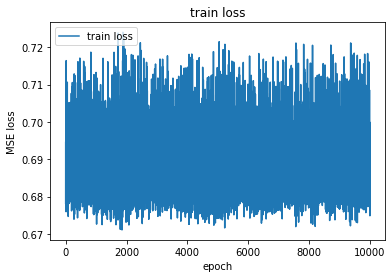

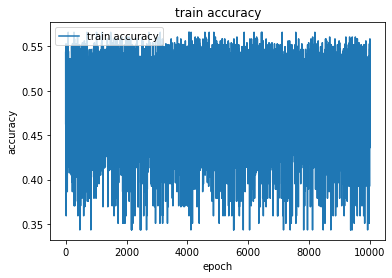

In [12]:
continueTrain = False

if (continueTrain):
    filename = './cells-256-500-30-v1.h5'
    model = keras.models.load_model(filename);
    versao += 1


history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, 
                        validation_steps=valid_steps, epochs=epochs);
filename = _fileName % (image_size, epochs, versao)
model.save(filename);
impHistoria(history)

In [13]:
model = keras.models.load_model(filename);
model.evaluate(valid_gen)

1/1 [==============================] - 0s 249ms/step - loss: 0.6992 - acc: 0.4485


[0.6992121934890747, 0.4485015869140625]

shape image:  (1, 256, 256, 3) shape mask:  (1, 256, 256, 1)
result_mask shape:  (1, 256, 256, 1)


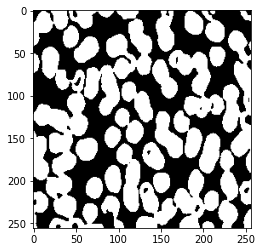

In [99]:

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);
result_mask = result_mask > 0.50; #float probability to bool conversion

plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
plt.show()




Text(0.5, 1.0, 'Predicted mask')

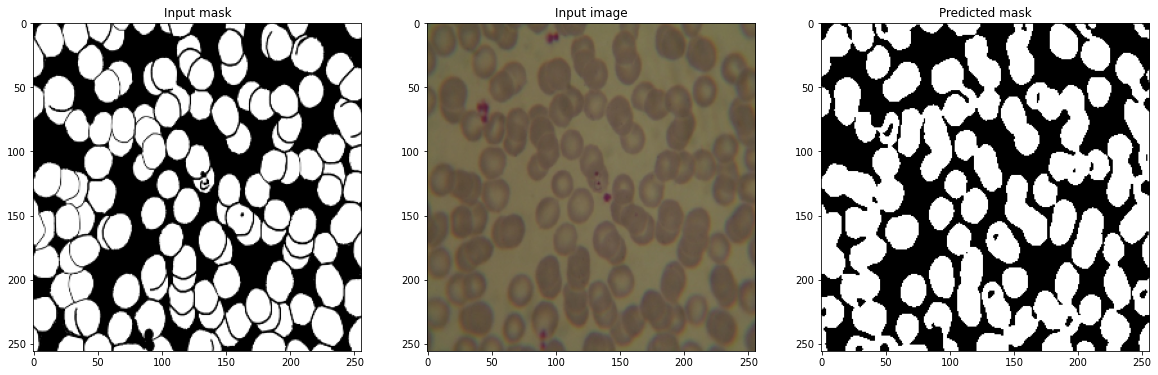

In [100]:
fig1 = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.4, wspace=.6)
i = 0;
my_plot = fig1.add_subplot(1, 3, 1)
plt.title("Input mask")
my_plot.imshow(np.reshape(p_mask[i]*255, (image_size, image_size)), cmap="gray")

my_plot = fig1.add_subplot(1, 3, 2);
p_image2 = p_image[i][:,:,::-1]
my_plot.imshow(p_image2);
plt.title("Input image")

my_plot = fig1.add_subplot(1, 3, 3)
my_plot.imshow(np.reshape(result_mask[i]*255, (image_size, image_size)), cmap="gray")
plt.title("Predicted mask")

result_mask shape:  (1, 256, 256, 1)


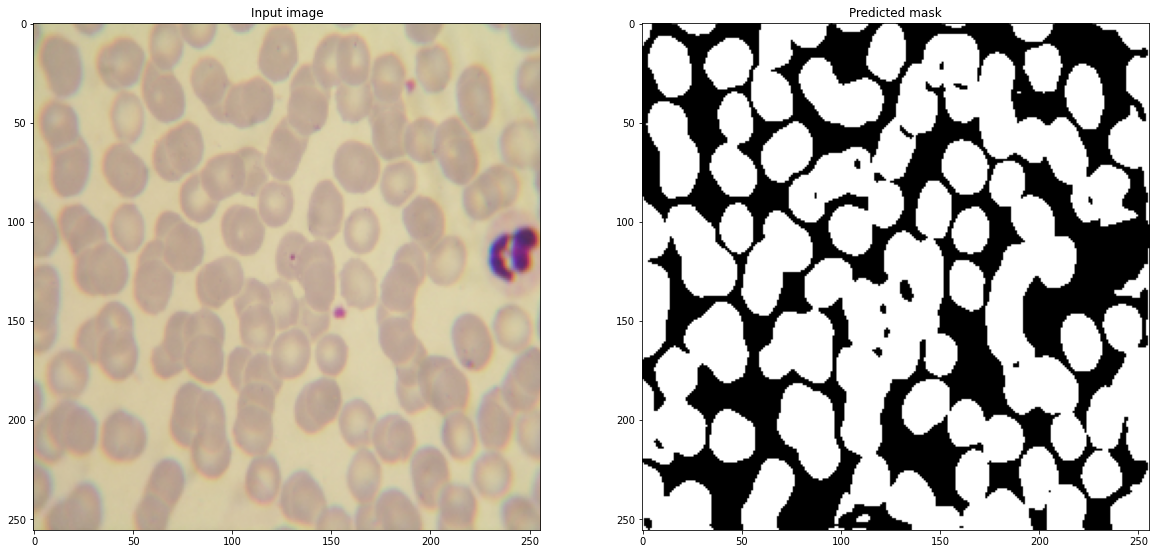

In [101]:
def load_img_norm(image_path, image_size):
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (image_size, image_size));# resizing input image to 128 * 128
        #image normalisation
        image = image / 255.0;
        
        image_r = []
        image_r.append(image);
        image_r = np.array(image_r);
        return image_r;

## Dataset for prediction
p_image = load_img_norm(gdrive+"/data-1024x1024/test/blood_smear_8.JPG",image_size)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);

#plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
#plt.show()

result_mask = result_mask > 0.30; #float probability to bool conversion

fig, ax = plt.subplots(ncols=2, figsize=(20,20))

res = p_image[0][:,:,::-1]
ax[0].imshow(res);
ax[0].title.set_text("Input image")

ax[1].imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
ax[1].title.set_text("Predicted mask")

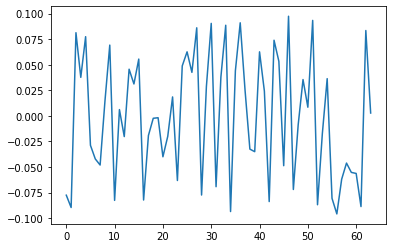

-0.09591128 0.097338915


In [57]:
inputs = keras.layers.Input((128, 128, 3))
c = keras.layers.Conv2D(64, (3,3), padding='same', strides=1, activation="relu")(inputs)
w = c.node.layer.get_weights()
w = w[0][0][0][0]
plt.plot(w)
plt.show()

print (min(w), max(w))

In [58]:
for i in range(10,31):
    image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_%d.png" % i)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    print("blood_smear_%d.png" % i)
    hist /= hist.sum()
    for i in range(256):
        if hist[i][0] > 0:
            print(i,end=",")
    print("")


blood_smear_10.png
0,255,
blood_smear_11.png
0,255,
blood_smear_12.png
0,255,
blood_smear_13.png
0,255,
blood_smear_14.png
0,255,
blood_smear_15.png
0,255,
blood_smear_16.png
0,255,
blood_smear_17.png
0,255,
blood_smear_18.png
0,255,
blood_smear_19.png
0,255,
blood_smear_20.png
0,255,
blood_smear_21.png
0,255,
blood_smear_22.png
0,255,
blood_smear_23.png
0,255,
blood_smear_24.png
0,255,
blood_smear_25.png
0,255,
blood_smear_26.png
0,255,
blood_smear_27.png
0,255,
blood_smear_28.png
0,255,
blood_smear_29.png
0,255,
blood_smear_30.png
0,255,


0
255


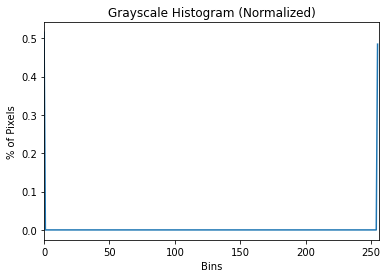

In [59]:
image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_1.png")
hist = cv2.calcHist([image], [0], None, [256], [0, 256])

hist /= hist.sum()
for i in range(256):
    if hist[i][0] > 0:
        print(i)
# plot the normalized histogram
plt.figure()
plt.title("Grayscale Histogram (Normalized)")
plt.xlabel("Bins")
plt.ylabel("% of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
plt.show()